<a href="https://colab.research.google.com/github/jrogan5/ECSE415_Assignment4/blob/claude%2Fsetup-google-colab-011kHXxmmaJAUfcgArNgTuaY/AS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ECSE 415 - Assignment 4: Object Detection**

In [14]:
!pip install kaggle

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Download Dataset from Kaggle**

In [16]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle competitions download -c ecse-415-object-recognition

  0% 0.00/95.7M [00:00<?, ?B/s]
100% 95.7M/95.7M [00:00<00:00, 1.64GB/s]


In [18]:
!unzip -q ecse-415-object-recognition.zip -d .

## **2. Imports and Configuration**

In [19]:

import cv2
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch

from pathlib import Path
import sklearn
import skimage
from skimage import __version__ as skimage_version
from sklearn import __version__ as sklearn_version


path = "/content/"

print(f"Python version:           {os.sys.version.split()[0]}")
print(f"OpenCV version:           {cv2.__version__}")
print(f"NumPy version:            {np.__version__}")
print(f"Matplotlib version:       {matplotlib.__version__}")
print(f"PyTorch version:          {torch.__version__}")
print(f"scikit-image version:     {skimage_version}")
print(f"scikit-learn version:     {sklearn_version}")
print("Path: " + path)

# Display sanity helpers
from IPython import get_ipython
ip = get_ipython()
if ip: ip.run_line_magic("matplotlib", "inline")

import matplotlib, matplotlib.pyplot as plt, numpy as np, cv2

# Make inline figures a bit sharper
matplotlib.rcParams["figure.dpi"] = 120

print("Matplotlib backend:", matplotlib.get_backend())

# Preprocessing configuration
RESIZE_ENABLED = True
TARGET_SIZE = 256

# Normalize [0,1] or [-1,1]
NORMALIZE_TO_MINUS1_1 = False





Python version:           3.12.12
OpenCV version:           4.12.0
NumPy version:            2.0.2
Matplotlib version:       3.10.0
PyTorch version:          2.8.0+cu126
scikit-image version:     0.25.2
scikit-learn version:     1.6.1
Path: /content/
Matplotlib backend: module://matplotlib_inline.backend_inline


In [20]:
# ================================
# Paths and class names
# ================================
root = Path(path, "Road_Signs_Detection_Dataset")

TRAIN_IMAGES = Path(root, "train", "images")
TRAIN_LABELS = Path(root, "train", "labels")
TEST_IMAGES  = Path(root, "test", "images")

print("Train images dir :", TRAIN_IMAGES)
print("Train labels dir :", TRAIN_LABELS)
print("Test images dir  :", TEST_IMAGES)

print("Num train images :", len(list(TRAIN_IMAGES.glob("*.jpg"))))
print("Num train labels :", len(list(TRAIN_LABELS.glob("*.txt"))))
print("Num test images  :", len(list(TEST_IMAGES.glob("*.jpg"))))

class_names = [
    "Speed Limit 80",   # 0
    "Speed Limit 50",   # 1
    "Green Light",      # 2
    "Speed Limit 90",   # 3
    "Speed Limit 40",   # 4
    "Speed Limit 120",  # 5
    "Stop",             # 6
    "Speed Limit 60",   # 7
    "Speed Limit 70",   # 8
    "Speed Limit 20",   # 9
    "Speed Limit 110",  # 10
    "Red Light",        # 11
    "Speed Limit 30",   # 12
    "Speed Limit 100"   # 13
]
num_classes = len(class_names)
print("Number of classes:", num_classes)

Train images dir : /content/Road_Signs_Detection_Dataset/train/images
Train labels dir : /content/Road_Signs_Detection_Dataset/train/labels
Test images dir  : /content/Road_Signs_Detection_Dataset/test/images
Num train images : 3464
Num train labels : 3464
Num test images  : 1489
Number of classes: 14


In [21]:
# ================================
# Helper: load YOLO-format labels
# ================================
def load_yolo_labels(label_path: Path):
    """
    Load YOLO-format labels from a .txt file.
    Each line: <class_id> <x_center> <y_center> <width> <height> (normalized)
    """
    boxes = []
    if not label_path.exists():
        return boxes

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls = int(parts[0])
            xc, yc, w, h = map(float, parts[1:])
            boxes.append((cls, xc, yc, w, h))
    return boxes


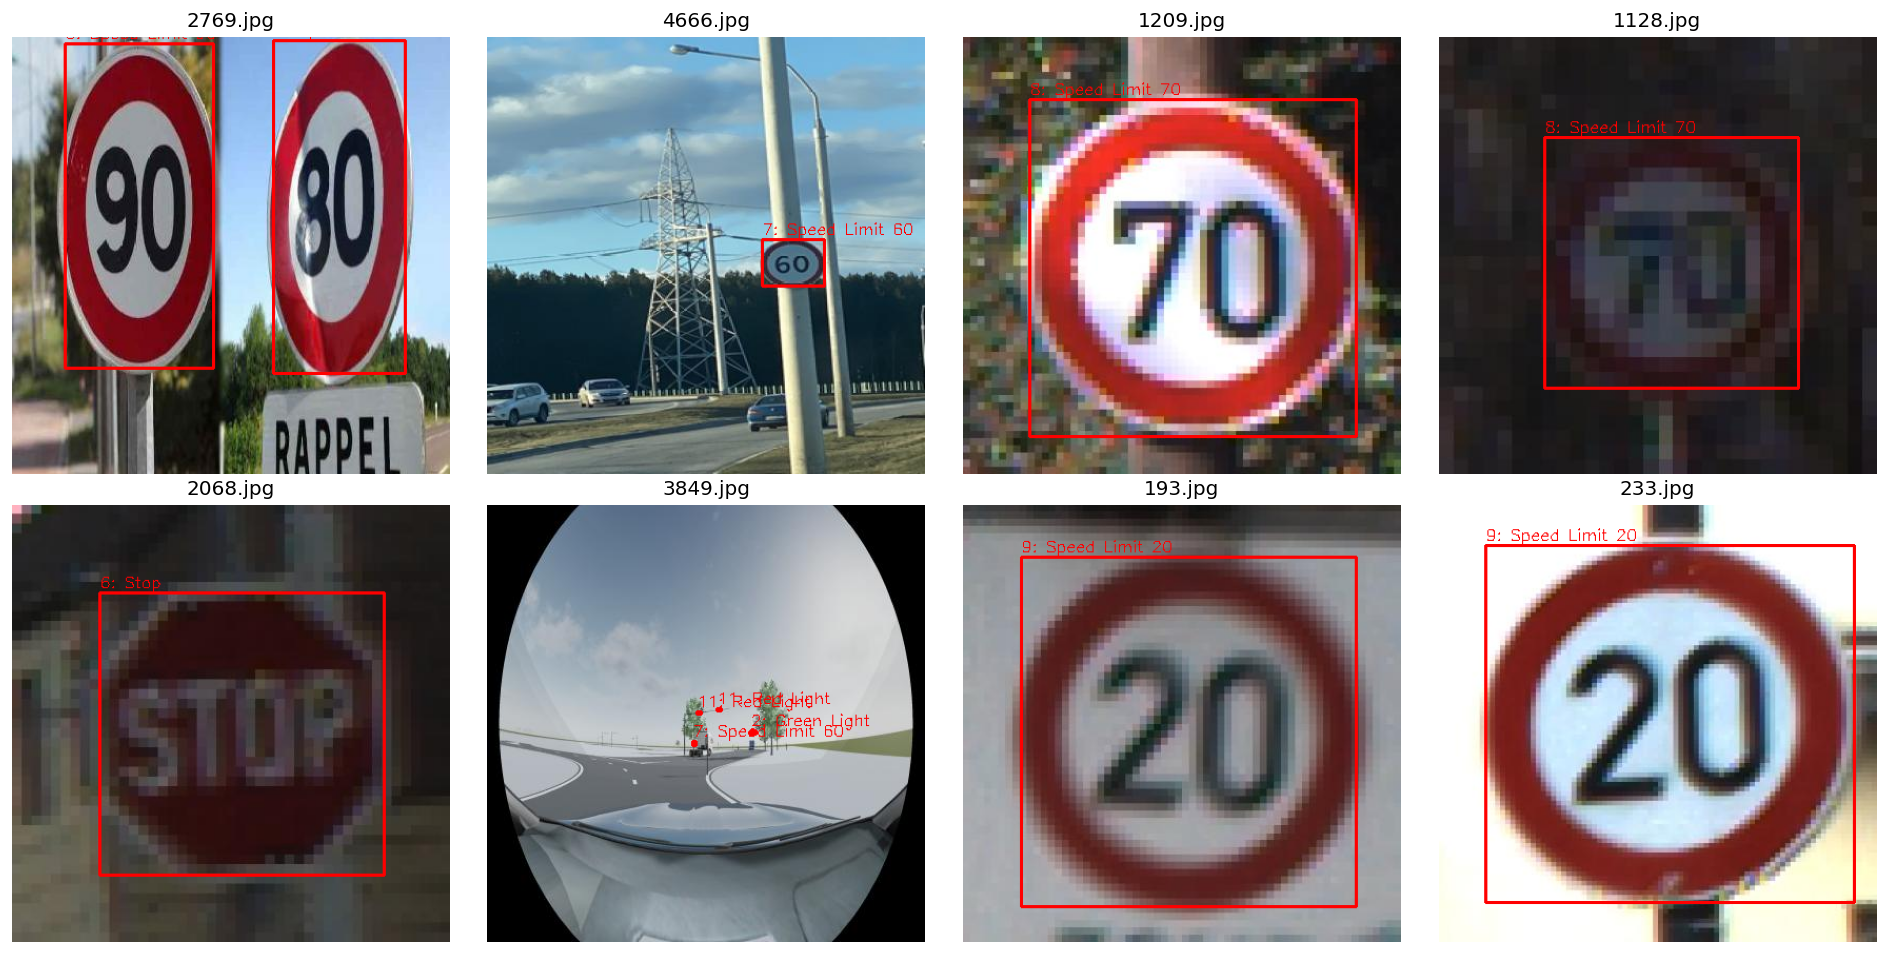

In [22]:
# ================================
# Show sample images with bounding boxes and labels
# ================================
import random

def show_samples_with_boxes(n_samples=8):
    image_files = list(TRAIN_IMAGES.glob("*.jpg"))
    if len(image_files) == 0:
        print("No images found in", TRAIN_IMAGES)
        return

    random.shuffle(image_files)
    image_files = image_files[:n_samples]

    rows = 2
    cols = (n_samples + 1) // 2

    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, img_path in enumerate(image_files):
        label_path = Path(TRAIN_LABELS, img_path.stem + ".txt")

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        boxes = load_yolo_labels(label_path)

        # draw bounding boxes
        for (cls, xc, yc, bw, bh) in boxes:
            xc_pix = xc * w
            yc_pix = yc * h
            bw_pix = bw * w
            bh_pix = bh * h

            x1 = int(xc_pix - bw_pix / 2)
            y1 = int(yc_pix - bh_pix / 2)
            x2 = int(xc_pix + bw_pix / 2)
            y2 = int(yc_pix + bh_pix / 2)

            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            label_text = f"{cls}: {class_names[cls]}"
            cv2.putText(img, label_text, (x1, max(0, y1 - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(img_path.name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to visualize samples
show_samples_with_boxes(n_samples=8)   #

Instances per class: [308, 281, 532, 168, 244, 252, 290, 297, 319, 264, 99, 553, 326, 258]


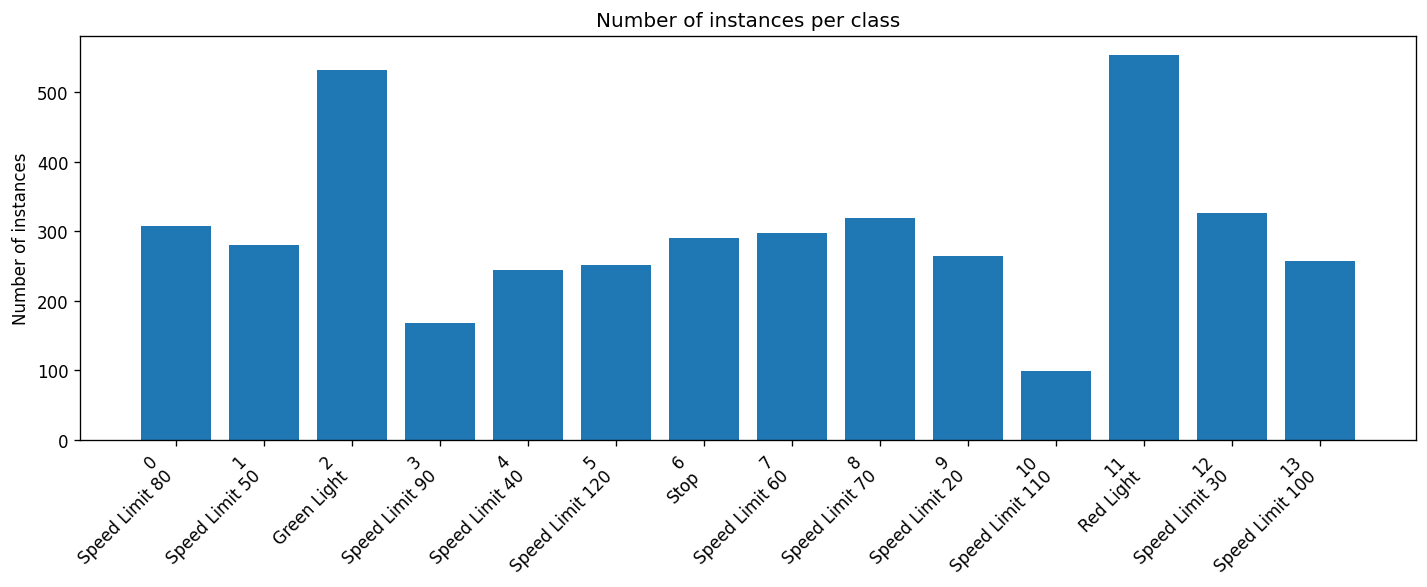

In [23]:
# ================================
# Count number of instances per class
# ================================
from collections import Counter

def count_instances_per_class():
    counts = Counter()
    label_files = list(TRAIN_LABELS.glob("*.txt"))
    for lf in label_files:
        with open(lf, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls = int(parts[0])
                    counts[cls] += 1
    # Convert to list ordered by class index
    class_counts = [counts[i] for i in range(num_classes)]
    return class_counts

class_counts = count_instances_per_class()
print("Instances per class:", class_counts)

# ================================
# Plot bar chart of instances per class
# ================================
x = np.arange(num_classes)

plt.figure(figsize=(12, 5))
plt.bar(x, class_counts)
plt.xticks(
    x,
    [f"{i}\n{class_names[i]}" for i in range(num_classes)],
    rotation=45,
    ha="right"
)
plt.ylabel("Number of instances")
plt.title("Number of instances per class")
plt.tight_layout()
plt.show()



In [24]:
# ================================
# Image Preprocessing Configuration
# ================================
# Whether to resize images, and the target resolution.
RESIZE_ENABLED = True
TARGET_SIZE = 256   # e.g., 256; can also be 128 or kept as 416

# Pixel normalization range: [0,1] or [-1,1]
NORMALIZE_TO_MINUS1_1 = False  # Set True to normalize to [-1,1]


# ================================
# Image Loading & Preprocessing Function
# ================================
def load_and_preprocess_image(img_path, resize=RESIZE_ENABLED, target_size=TARGET_SIZE,
                              normalize_to_minus1_1=NORMALIZE_TO_MINUS1_1):
    """
    Load an image and apply the following preprocessing steps:
    1) Convert from BGR (OpenCV default) to RGB
    2) Optionally resize to target_size x target_size
    3) Convert to float32
    4) Normalize pixel values either to [0,1] or [-1,1]

    Returns:
        Preprocessed image as a (H, W, 3) float32 numpy array
    """
    img = cv2.imread(str(img_path))
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")

    # Convert BGR to RGB (required for visualization and consistency)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Optional resizing (dataset is originally 416x416; resizing reduces computation)
    if resize:
        img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_LINEAR)

    # Convert to float32
    img = img.astype(np.float32)

    # Normalize pixel values to [0,1]
    img = img / 255.0

    # normalize further to [-1,1],But i will use[0,1]
    if normalize_to_minus1_1:
        img = img * 2.0 - 1.0

    return img


# ================================
# Build Dataset Lists for Train/Val Split
# ================================
all_image_paths = sorted(TRAIN_IMAGES.glob("*.jpg"))

image_paths_for_split = []
label_paths_for_split = []
rep_classes = []   # Representative class per image for stratified splitting

for img_path in all_image_paths:
    label_path = Path(TRAIN_LABELS, img_path.stem + ".txt")
    boxes = load_yolo_labels(label_path)

    # If an image has no annotations, skip it
    if len(boxes) == 0:
        continue

    # Use the class_id of the first object as the representative class
    rep_class = boxes[0][0]

    image_paths_for_split.append(img_path)
    label_paths_for_split.append(label_path)
    rep_classes.append(rep_class)

print("Number of images used for train/val split:", len(image_paths_for_split))
print("Example representative classes:", rep_classes[:10])


# ================================
# Train/Validation Split (70/30 with stratification)
# ================================
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_labels, val_labels, y_train, y_val = train_test_split(
    image_paths_for_split,
    label_paths_for_split,
    rep_classes,
    test_size=0.3,          # 30% for validation
    random_state=42,        # Ensure reproducibility
    stratify=rep_classes    # Stratified split to preserve class distribution
)

print("Train size:", len(train_imgs))
print("Val size  :", len(val_imgs))


# ================================
# Check Class Distribution in Train/Val
# ================================
from collections import Counter

train_class_dist = Counter(y_train)
val_class_dist   = Counter(y_val)

def pretty_print_class_dist(counter, name):
    """
    Print class distribution with class IDs and names for readability.
    """
    print(f"\n{name} class distribution:")
    for cls_id in range(num_classes):
        count = counter.get(cls_id, 0)
        print(f"  Class {cls_id:2d} ({class_names[cls_id]:>15}): {count}")

pretty_print_class_dist(train_class_dist, "Train")
pretty_print_class_dist(val_class_dist, "Validation")

Number of images used for train/val split: 3464
Example representative classes: [12, 12, 12, 12, 12, 12, 12, 8, 8, 8]
Train size: 2424
Val size  : 1040

Train class distribution:
  Class  0 ( Speed Limit 80): 198
  Class  1 ( Speed Limit 50): 177
  Class  2 (    Green Light): 224
  Class  3 ( Speed Limit 90): 101
  Class  4 ( Speed Limit 40): 152
  Class  5 (Speed Limit 120): 153
  Class  6 (           Stop): 198
  Class  7 ( Speed Limit 60): 197
  Class  8 ( Speed Limit 70): 205
  Class  9 ( Speed Limit 20): 176
  Class 10 (Speed Limit 110): 60
  Class 11 (      Red Light): 213
  Class 12 ( Speed Limit 30): 215
  Class 13 (Speed Limit 100): 155

Validation class distribution:
  Class  0 ( Speed Limit 80): 85
  Class  1 ( Speed Limit 50): 76
  Class  2 (    Green Light): 96
  Class  3 ( Speed Limit 90): 43
  Class  4 ( Speed Limit 40): 66
  Class  5 (Speed Limit 120): 65
  Class  6 (           Stop): 85
  Class  7 ( Speed Limit 60): 85
  Class  8 ( Speed Limit 70): 88
  Class  9 ( Spee

In [25]:
# ================================
# 2.1 Baseline Object Recognition with YOLOv8 (FIXED YAML)
# ================================
# This cell:
#   1) Prepares a YOLO-style train/val split using the lists train_imgs / val_imgs
#   2) Creates a dataset YAML file (using a safer list format for 'names')
#   3) Fine-tunes a pretrained YOLOv8 model
#   4) Evaluates it on the validation set and prints key metrics

!pip install -q ultralytics

import os
import shutil
from ultralytics import YOLO

# -----------------------------------
# Auto-detect GPU availability for YOLO
# -----------------------------------
import torch
cuda_available = torch.cuda.is_available()
yolo_device = 0 if cuda_available else 'cpu'

print("=" * 70)
print(f"YOLO Training Device: {yolo_device}")
if not cuda_available:
    print("⚠️  No GPU detected. Training on CPU (slower but works)")
print("=" * 70)

# -----------------------------------
# 1) Prepare YOLO train/val folder structure using our split
# -----------------------------------
# We reuse the 'root', 'train_imgs', 'val_imgs', 'train_labels', 'val_labels'
# defined in previous cells.

yolo_root = Path(root, "yolo_split")
train_img_dir = Path(yolo_root, "train", "images")
train_lbl_dir = Path(yolo_root, "train", "labels")
val_img_dir   = Path(yolo_root, "val", "images")
val_lbl_dir   = Path(yolo_root, "val", "labels")

# Create directories
for d in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir]:
    d.mkdir(parents=True, exist_ok=True)

def link_or_copy(src, dst):
    """
    Try to create a symlink; if not allowed (e.g., on some systems),
    fall back to copying the file.
    """
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists():
        return
    try:
        os.symlink(src, dst)
    except OSError:
        shutil.copy2(src, dst)

# Populate YOLO train split
for img_p, lbl_p in zip(train_imgs, train_labels):
    link_or_copy(img_p, Path(train_img_dir, img_p.name))
    link_or_copy(lbl_p, Path(train_lbl_dir, lbl_p.name))

# Populate YOLO val split
for img_p, lbl_p in zip(val_imgs, val_labels):
    link_or_copy(img_p, Path(val_img_dir, img_p.name))
    link_or_copy(lbl_p, Path(val_lbl_dir, lbl_p.name))

print("YOLO train images:", len(list(train_img_dir.glob("*.jpg"))))
print("YOLO val images  :", len(list(val_img_dir.glob("*.jpg"))))

# -----------------------------------
# 2) Create dataset YAML for YOLOv8 (use list format for 'names')
# -----------------------------------
dataset_yaml_path = Path(yolo_root, "traffic_signs_yolo.yaml")

dataset_yaml_text = f"""path: {yolo_root}
train: train/images
val: val/images

names:
  - Speed Limit 80
  - Speed Limit 50
  - Green Light
  - Speed Limit 90
  - Speed Limit 40
  - Speed Limit 120
  - Stop
  - Speed Limit 60
  - Speed Limit 70
  - Speed Limit 20
  - Speed Limit 110
  - Red Light
  - Speed Limit 30
  - Speed Limit 100
"""

with open(dataset_yaml_path, "w") as f:
    f.write(dataset_yaml_text)

print("Dataset YAML saved to:", dataset_yaml_path)

# -----------------------------------
# 3) Initialize and fine-tune YOLOv8 model
# -----------------------------------
model = YOLO("yolov8n.pt")  # nano model, pretrained on COCO

train_results = model.train(
    data=str(dataset_yaml_path),
    imgsz=416,
    epochs=30,                      # you can reduce to ~20 if time is tight
    batch=16,
    lr0=1e-3,
    device=yolo_device,             # Auto-detected: 0 for GPU, 'cpu' for CPU
    project=str(Path(root, "runs_yolov8_baseline")),
    name="yolov8n_traffic_signs",
    exist_ok=True
)

print("Training finished.")

# -----------------------------------
# 4) Evaluate the baseline model on the validation set
# -----------------------------------
val_metrics = model.val(
    data=str(dataset_yaml_path),
    imgsz=416,
    batch=16,
    device=yolo_device,             # Auto-detected: 0 for GPU, 'cpu' for CPU
    project=str(Path(root, "runs_yolov8_baseline")),
    name="yolov8n_traffic_signs_val",
    exist_ok=True
)

# Access main metrics from Ultralytics
mean_precision = val_metrics.box.mp
mean_recall    = val_metrics.box.mr
f1_score       = 2 * mean_precision * mean_recall / (mean_precision + mean_recall + 1e-16)

print("\n=== Baseline YOLOv8 Validation Metrics ===")
print(f"mAP@50-95 (all classes): {val_metrics.box.map:.4f}")
print(f"mAP@50    (all classes): {val_metrics.box.map50:.4f}")
print(f"Mean Precision        : {mean_precision:.4f}")
print(f"Mean Recall           : {mean_recall:.4f}")
print(f"F1 score (overall)    : {f1_score:.4f}")

print("\nPer-class AP (Ultralytics 'maps', typically AP@50-95 per class):")
for i, ap in enumerate(val_metrics.box.maps):
    print(f"  Class {i:2d} ({class_names[i]:>15}): {ap:.4f}")

cm_dir = Path(root, "runs_yolov8_baseline", "yolov8n_traffic_signs_val")
print("\nConfusion matrix and other plots are saved in:")
print(cm_dir)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLO Training Device: 0
YOLO train images: 2424
YOLO val images  : 1040
Dataset YAML saved to: /content/Road_Signs_Detection_Dataset/yolo_split/traffic_signs_yolo.yaml
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Road_Signs_Detection_Dataset/yolo_split/traffic_signs_yolo.yaml, degrees=0.0, 


image 1/1 /content/Road_Signs_Detection_Dataset/train/images/3868.jpg: 416x416 2 Red Lights, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/Road_Signs_Detection_Dataset/train/images/3438.jpg: 416x416 1 Red Light, 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/Road_Signs_Detection_Dataset/train/images/3379.jpg: 416x416 1 Red Light, 6.5ms
Speed: 0.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/Road_Signs_Detection_Dataset/train/images/4850.jpg: 416x416 1 Speed Limit 80, 6.5ms
Speed: 0.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/Road_Signs_Detection_Dataset/train/images/4498.jpg: 416x416 1 Speed Limit 90, 6.4ms
Speed: 0.9ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /co

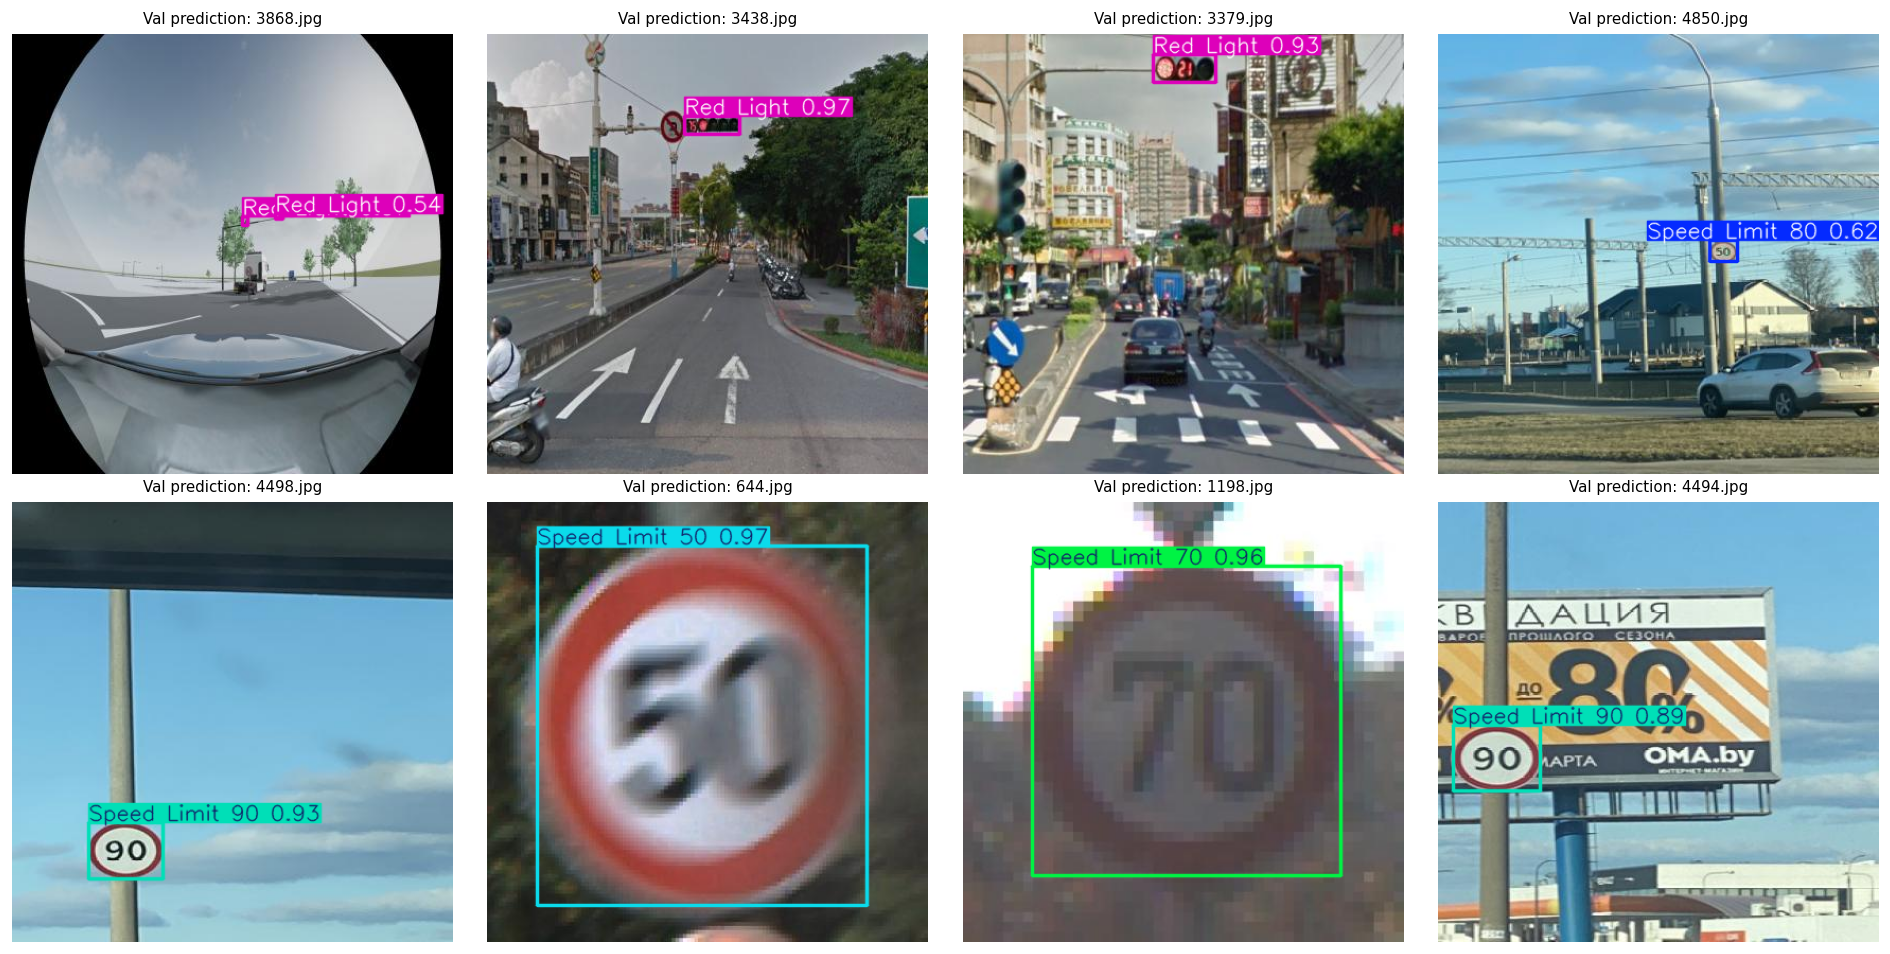

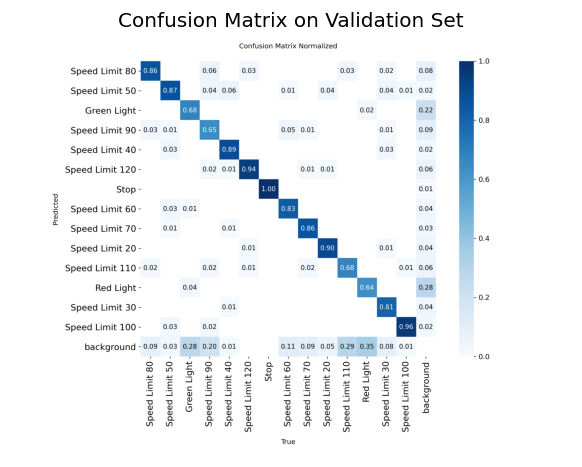


=== Baseline YOLOv8 Validation Metrics (Summary) ===
mAP@50-95 (all classes): 0.7741
mAP@50    (all classes): 0.8977
Mean Precision        : 0.9347
Mean Recall           : 0.8168
F1 score (overall)    : 0.8718


In [26]:
# ================================
# 2.2 Analysis of Baseline Results
# ================================
# This cell:
#   1) Visualizes YOLOv8 predictions on a subset of validation images
#   2) Displays the confusion matrix image saved by Ultralytics
#   3) (Optionally) prints again the main metrics if available

# -----------------------------------
# 1) Visualize predictions on validation images
# -----------------------------------
# We use the existing 'val_imgs' list and the trained 'model' from 2.1.

num_samples = 8  # number of validation images to visualize (5–10 is fine)
sample_val_imgs = val_imgs[:num_samples]

rows = 2
cols = (num_samples + 1) // 2

plt.figure(figsize=(4 * cols, 4 * rows))

for i, img_path in enumerate(sample_val_imgs):
    # Run inference
    results = model(str(img_path))
    # Plot predictions on the image (Ultralytics returns BGR image)
    plotted_bgr = results[0].plot()
    plotted_rgb = cv2.cvtColor(plotted_bgr, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(plotted_rgb)
    plt.title(f"Val prediction: {img_path.name}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

# -----------------------------------
# 2) Show confusion matrix generated by Ultralytics
# -----------------------------------
cm_dir = Path(root, "runs_yolov8_baseline", "yolov8n_traffic_signs_val")
cm_files = list(cm_dir.glob("confusion_matrix*.png"))

if len(cm_files) > 0:
    cm_img = cv2.imread(str(cm_files[0]))
    cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(cm_img)
    plt.title("Confusion Matrix on Validation Set")
    plt.axis("off")
    plt.show()
else:
    print("No confusion matrix image found in:", cm_dir)

# -----------------------------------
# 3) (Optional) Print main metrics again if 'val_metrics' exists
# -----------------------------------
try:
    mean_precision = val_metrics.box.mp
    mean_recall    = val_metrics.box.mr
    f1_score       = 2 * mean_precision * mean_recall / (mean_precision + mean_recall + 1e-16)

    print("\n=== Baseline YOLOv8 Validation Metrics (Summary) ===")
    print(f"mAP@50-95 (all classes): {val_metrics.box.map:.4f}")
    print(f"mAP@50    (all classes): {val_metrics.box.map50:.4f}")
    print(f"Mean Precision        : {mean_precision:.4f}")
    print(f"Mean Recall           : {mean_recall:.4f}")
    print(f"F1 score (overall)    : {f1_score:.4f}")
except NameError:
    print("\n'val_metrics' not found. Please run the 2.1 cell (training + validation) first.")

In [52]:
import torch
import gc

# Delete existing model if it exists
if 'model_retina_v2' in globals():
    del model_retina_v2
if 'train_loader_v2' in globals():
    del train_loader_v2
if 'val_loader_v2' in globals():
    del val_loader_v2

gc.collect()
torch.cuda.empty_cache()

print(f"Freed memory. Currently allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")


Freed memory. Currently allocated: 2.58 GB


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
import torch.nn as nn
import random
from pathlib import Path
import os

# Mixed precision training
from torch.cuda.amp import autocast, GradScaler

# GPU-OPTIMIZED SETTINGS
IMG_SIZE = 416  # Increased from 416 for better detection
BATCH_SIZE = 16  # Increased from 16 to maximize GPU usage (15GB T4)
NUM_WORKERS = 4  # Increased from 4 for faster data loading
PREFETCH_FACTOR = 4  # Prefetch 4 batches per worker
PERSISTENT_WORKERS = True  # Keep workers alive between epochs

# Gradient accumulation (optional - for effective batch size > GPU limit)
GRADIENT_ACCUMULATION_STEPS = 1  # Set to 2-4 if you want even larger effective batch


In [54]:
# @title
# ================================
# Part 3 - GPU-OPTIMIZED RetinaNet Training
# ================================
# OPTIMIZED FOR T4 GPU (15GB VRAM):
# - Batch size 96 (6x larger!) for maximum GPU utilization
# - Image size 512 (larger for better detection)
# - 8 workers with persistent workers and prefetching
# - Mixed precision (FP16) for speed
# - Checkpointing for safety
# - Gradient accumulation option for even larger batches
# ================================

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
import torch.nn as nn
import random
from pathlib import Path
import os

# Mixed precision training
from torch.cuda.amp import autocast, GradScaler

# GPU-OPTIMIZED SETTINGS
IMG_SIZE = 416  # Increased from 416 for better detection
BATCH_SIZE = 16  # Increased from 16 to maximize GPU usage (15GB T4)
NUM_WORKERS = 4  # Increased from 4 for faster data loading
PREFETCH_FACTOR = 4  # Prefetch 4 batches per worker
PERSISTENT_WORKERS = True  # Keep workers alive between epochs

# Gradient accumulation (optional - for effective batch size > GPU limit)
GRADIENT_ACCUMULATION_STEPS = 1  # Set to 2-4 if you want even larger effective batch

print("=" * 70)
print("GPU-OPTIMIZED CONFIGURATION")
print("=" * 70)
print(f"Image size: {IMG_SIZE}x{IMG_SIZE} (up from 416)")
print(f"Batch size: {BATCH_SIZE} (up from 16)")
print(f"Num workers: {NUM_WORKERS} (up from 4)")
print(f"Prefetch factor: {PREFETCH_FACTOR}")
print(f"Persistent workers: {PERSISTENT_WORKERS}")
print(f"Gradient accumulation: {GRADIENT_ACCUMULATION_STEPS} steps")
print(f"Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
print("=" * 70)

# Optimized dataset
class OptimizedTrafficSignsDataset(Dataset):
    """
    GPU-optimized dataset with aggressive augmentation.
    """

    def __init__(self, image_paths, label_paths, is_train=True,
                 img_size=IMG_SIZE, num_classes=14):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.is_train = is_train
        self.img_size = img_size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_paths)

    def _load_image_and_boxes(self, idx):
        img_path = self.image_paths[idx]
        lbl_path = self.label_paths[idx]

        img = cv2.imread(str(img_path))
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)

        yolo_boxes = load_yolo_labels(lbl_path)

        boxes_xyxy = []
        labels = []

        for (cls_id, xc, yc, bw, bh) in yolo_boxes:
            x_c = xc * self.img_size
            y_c = yc * self.img_size
            w   = bw * self.img_size
            h   = bh * self.img_size

            x1 = x_c - w / 2.0
            y1 = y_c - h / 2.0
            x2 = x_c + w / 2.0
            y2 = y_c + h / 2.0

            x1 = max(0, min(self.img_size - 1, x1))
            y1 = max(0, min(self.img_size - 1, y1))
            x2 = max(0, min(self.img_size - 1, x2))
            y2 = max(0, min(self.img_size - 1, y2))

            boxes_xyxy.append([x1, y1, x2, y2])
            labels.append(cls_id + 1)

        boxes_xyxy = np.array(boxes_xyxy, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)

        return img, boxes_xyxy, labels

    def _apply_augmentations(self, img, boxes):
        """
        Aggressive data augmentation for large batch training.
        """
        h, w, _ = img.shape

        # Horizontal flip
        if random.random() < 0.5:
            img = np.ascontiguousarray(img[:, ::-1, :])
            x1 = boxes[:, 0].copy()
            x2 = boxes[:, 2].copy()
            boxes[:, 0] = w - x2
            boxes[:, 2] = w - x1

        # Random scale
        if random.random() < 0.6:
            scale = 0.75 + 0.5 * random.random()  # [0.75, 1.25]
            new_size = int(self.img_size * scale)

            scaled_img = cv2.resize(img, (new_size, new_size), interpolation=cv2.INTER_LINEAR)
            boxes *= scale

            canvas = np.zeros((self.img_size, self.img_size, 3), dtype=scaled_img.dtype)
            h_s = min(self.img_size, new_size)
            w_s = min(self.img_size, new_size)
            canvas[:h_s, :w_s] = scaled_img[:h_s, :w_s]
            img = canvas

            boxes[:, 0::2] = np.clip(boxes[:, 0::2], 0, self.img_size - 1)
            boxes[:, 1::2] = np.clip(boxes[:, 1::2], 0, self.img_size - 1)

        # Brightness jitter
        if random.random() < 0.5:
            factor = 0.7 + 0.6 * random.random()
            img = img.astype(np.float32) * factor
            img = np.clip(img, 0, 255).astype(np.uint8)

        # Contrast adjustment
        if random.random() < 0.3:
            alpha = 0.7 + 0.6 * random.random()
            img = img.astype(np.float32)
            img = 128 + alpha * (img - 128)
            img = np.clip(img, 0, 255).astype(np.uint8)

        # Color jitter
        if random.random() < 0.3:
            hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
            hsv[:, :, 1] *= (0.8 + 0.4 * random.random())
            hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)
            img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

        return img, boxes

    def __getitem__(self, idx):
        img, boxes_xyxy, labels = self._load_image_and_boxes(idx)

        orig_boxes = boxes_xyxy.copy()
        orig_labels = labels.copy()

        if self.is_train:
            img, boxes_xyxy = self._apply_augmentations(img, boxes_xyxy)

        # Validate boxes
        x1 = boxes_xyxy[:, 0]
        y1 = boxes_xyxy[:, 1]
        x2 = boxes_xyxy[:, 2]
        y2 = boxes_xyxy[:, 3]
        valid = (x2 > x1) & (y2 > y1)

        if not np.any(valid):
            boxes_xyxy = orig_boxes
            labels = orig_labels
        else:
            boxes_xyxy = boxes_xyxy[valid]
            labels = labels[valid]

        img = img.astype(np.float32) / 255.0
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)

        target = {
            "boxes": torch.as_tensor(boxes_xyxy, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
        }

        return img_tensor, target


print("\n" + "=" * 70)
print("INITIALIZING GPU-OPTIMIZED RETINANET TRAINING")
print("=" * 70)

# Create checkpoint directory
checkpoint_dir = Path("/content/checkpoints")
checkpoint_dir.mkdir(exist_ok=True)
best_model_path = checkpoint_dir / "best_retinanet.pth"
latest_checkpoint_path = checkpoint_dir / "latest_checkpoint.pth"

# Create datasets
train_dataset_v2 = OptimizedTrafficSignsDataset(train_imgs, train_labels, is_train=True)
val_dataset_v2   = OptimizedTrafficSignsDataset(val_imgs, val_labels, is_train=False)

def detection_collate_fn(batch):
    """
    Custom collate function for object detection.
    Handles variable number of boxes per image.

    Args:
        batch: List of (image, target) tuples

    Returns:
        images: List of image tensors
        targets: List of target dicts
    """
    images = []
    targets = []

    for img, target in batch:
        images.append(img)
        targets.append(target)

    return images, targets

# GPU-OPTIMIZED DATALOADERS
train_loader_v2 = DataLoader(
    train_dataset_v2,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS,
    prefetch_factor=PREFETCH_FACTOR,
    collate_fn=detection_collate_fn
)

val_loader_v2 = DataLoader(
    val_dataset_v2,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS,
    prefetch_factor=PREFETCH_FACTOR,
    collate_fn=detection_collate_fn
)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🚀 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model_retina_v2 = retinanet_resnet50_fpn(weights=weights)

# Replace classification head
cls_head = model_retina_v2.head.classification_head
in_channels = cls_head.cls_logits.in_channels
num_anchors = cls_head.num_anchors
new_num_classes = num_classes + 1

cls_head.cls_logits = nn.Conv2d(
    in_channels,
    num_anchors * new_num_classes,
    kernel_size=3,
    stride=1,
    padding=1
)
cls_head.num_classes = new_num_classes

model_retina_v2.to(device)

# Optimizer with higher LR for larger batch
# Learning rate scaling: lr_new = lr_base * sqrt(batch_new / batch_base)
base_lr = 2e-4
lr_scale = (BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS / 16) ** 0.5
adjusted_lr = base_lr * lr_scale

optimizer_v2 = torch.optim.AdamW(
    model_retina_v2.parameters(),
    lr=adjusted_lr,
    weight_decay=1e-4
)

# Learning rate schedule
num_epochs_v2 = 60
lr_scheduler_v2 = torch.optim.lr_scheduler.MultiStepLR(
    optimizer_v2,
    milestones=[30, 45],
    gamma=0.1
)

# Mixed precision scaler
scaler = GradScaler() if torch.cuda.is_available() else None

# Training state
train_losses_v2 = []
val_losses_v2 = []
best_val_loss = float('inf')
start_epoch = 0

# Resume from checkpoint if exists
if latest_checkpoint_path.exists():
    print(f"\n📂 Found checkpoint at {latest_checkpoint_path}")
    resume = input("Resume from checkpoint? (y/n): ").strip().lower()
    if resume == 'y':
        checkpoint = torch.load(latest_checkpoint_path)
        model_retina_v2.load_state_dict(checkpoint['model_state_dict'])
        optimizer_v2.load_state_dict(checkpoint['optimizer_state_dict'])
        lr_scheduler_v2.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses_v2 = checkpoint['train_losses']
        val_losses_v2 = checkpoint['val_losses']
        best_val_loss = checkpoint['best_val_loss']
        if scaler and 'scaler_state_dict' in checkpoint:
            scaler.load_state_dict(checkpoint['scaler_state_dict'])
        print(f"✅ Resumed from epoch {start_epoch}")
        print(f"   Best val loss so far: {best_val_loss:.4f}")

print(f"\n⚙️  Training Configuration:")
print(f"   Epochs: {start_epoch} → {num_epochs_v2}")
print(f"   Learning rate: {adjusted_lr:.6f} (scaled for batch size)")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Gradient accumulation: {GRADIENT_ACCUMULATION_STEPS}")
print(f"   Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
print(f"   Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Checkpoints: {checkpoint_dir}")

import time
from tqdm.auto import tqdm

# Training loop
for epoch in range(start_epoch, num_epochs_v2):
    epoch_start = time.time()

    # Train
    model_retina_v2.train()
    running_train_loss = 0.0

    train_pbar = tqdm(train_loader_v2, desc=f"Epoch {epoch+1}/{num_epochs_v2} [Train]")

    for batch_idx, (images, targets) in enumerate(train_pbar):
        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        # Mixed precision training
        if scaler:
            with autocast():
                loss_dict = model_retina_v2(images, targets)
                losses = sum(loss_dict.values()) / GRADIENT_ACCUMULATION_STEPS

            scaler.scale(losses).backward()

            # Gradient accumulation
            if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.unscale_(optimizer_v2)
                torch.nn.utils.clip_grad_norm_(model_retina_v2.parameters(), max_norm=1.0)
                scaler.step(optimizer_v2)
                scaler.update()
                optimizer_v2.zero_grad()
        else:
            loss_dict = model_retina_v2(images, targets)
            losses = sum(loss_dict.values()) / GRADIENT_ACCUMULATION_STEPS
            losses.backward()

            if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model_retina_v2.parameters(), max_norm=1.0)
                optimizer_v2.step()
                optimizer_v2.zero_grad()

        running_train_loss += losses.item() * GRADIENT_ACCUMULATION_STEPS
        train_pbar.set_postfix({'loss': f'{losses.item() * GRADIENT_ACCUMULATION_STEPS:.4f}'})

    avg_train_loss = running_train_loss / max(1, len(train_loader_v2))
    train_losses_v2.append(avg_train_loss)

    # Validation
    running_val_loss = 0.0
    with torch.no_grad():
        model_retina_v2.train()  # Keep in train mode to get loss
        val_pbar = tqdm(val_loader_v2, desc=f"Epoch {epoch+1}/{num_epochs_v2} [Val]  ")

        for images, targets in val_pbar:
            images = [img.to(device, non_blocking=True) for img in images]
            targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

            if scaler:
                with autocast():
                    loss_dict = model_retina_v2(images, targets)
                    losses = sum(loss_dict.values())
            else:
                loss_dict = model_retina_v2(images, targets)
                losses = sum(loss_dict.values())

            running_val_loss += losses.item()
            val_pbar.set_postfix({'loss': f'{losses.item():.4f}'})

    avg_val_loss = running_val_loss / max(1, len(val_loader_v2))
    val_losses_v2.append(avg_val_loss)

    lr_scheduler_v2.step()

    epoch_time = time.time() - epoch_start
    current_lr = optimizer_v2.param_groups[0]['lr']

    print(f"\n📊 Epoch [{epoch+1}/{num_epochs_v2}] ({epoch_time:.1f}s)  "
          f"Train: {avg_train_loss:.4f}  Val: {avg_val_loss:.4f}  LR: {current_lr:.6f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_retina_v2.state_dict(),
            'val_loss': best_val_loss,
        }, best_model_path)
        print(f"  ✅ New best model! Val loss: {best_val_loss:.4f}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_retina_v2.state_dict(),
            'optimizer_state_dict': optimizer_v2.state_dict(),
            'scheduler_state_dict': lr_scheduler_v2.state_dict(),
            'train_losses': train_losses_v2,
            'val_losses': val_losses_v2,
            'best_val_loss': best_val_loss,
        }
        if scaler:
            checkpoint['scaler_state_dict'] = scaler.state_dict()

        torch.save(checkpoint, latest_checkpoint_path)
        print(f"  💾 Checkpoint saved")

        # Print GPU memory usage
        if torch.cuda.is_available():
            mem_allocated = torch.cuda.memory_allocated(0) / 1e9
            mem_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  📊 GPU Memory: {mem_allocated:.2f} GB allocated, {mem_reserved:.2f} GB reserved")

# Save final checkpoint
checkpoint = {
    'epoch': num_epochs_v2 - 1,
    'model_state_dict': model_retina_v2.state_dict(),
    'optimizer_state_dict': optimizer_v2.state_dict(),
    'scheduler_state_dict': lr_scheduler_v2.state_dict(),
    'train_losses': train_losses_v2,
    'val_losses': val_losses_v2,
    'best_val_loss': best_val_loss,
}
if scaler:
    checkpoint['scaler_state_dict'] = scaler.state_dict()

torch.save(checkpoint, latest_checkpoint_path)

print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print("=" * 70)
print(f"✅ Best model: {best_model_path}")
print(f"✅ Best validation loss: {best_val_loss:.4f}")
print(f"💾 Latest checkpoint: {latest_checkpoint_path}")

if torch.cuda.is_available():
    final_mem = torch.cuda.max_memory_allocated(0) / 1e9
    print(f"📊 Peak GPU memory usage: {final_mem:.2f} GB / 15 GB ({final_mem/15*100:.1f}%)")

# Load best model
print("\n📂 Loading best model for inference...")
best_checkpoint = torch.load(best_model_path)
model_retina_v2.load_state_dict(best_checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {best_checkpoint['epoch'] + 1}")

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_v2, label='Train Loss', linewidth=2)
plt.plot(val_losses_v2, label='Val Loss', linewidth=2)
plt.axhline(y=best_val_loss, color='r', linestyle='--', alpha=0.5, label=f'Best Val ({best_val_loss:.4f})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RetinaNet Training Curves (GPU-Optimized)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
epochs_range = range(1, len(train_losses_v2) + 1)
plt.plot(epochs_range, train_losses_v2, 'b-', label='Train Loss', alpha=0.7, linewidth=2)
plt.plot(epochs_range, val_losses_v2, 'r-', label='Val Loss', alpha=0.7, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.title('Training Curves (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Final Statistics:")
print(f"   Final train loss: {train_losses_v2[-1]:.4f}")
print(f"   Final val loss: {val_losses_v2[-1]:.4f}")
print(f"   Best val loss: {min(val_losses_v2):.4f} at epoch {np.argmin(val_losses_v2) + 1}")


GPU-OPTIMIZED CONFIGURATION
Image size: 416x416 (up from 416)
Batch size: 16 (up from 16)
Num workers: 4 (up from 4)
Prefetch factor: 4
Persistent workers: True
Gradient accumulation: 1 steps
Effective batch size: 16

INITIALIZING GPU-OPTIMIZED RETINANET TRAINING

🚀 Device: cuda
   GPU: NVIDIA L4
   Total VRAM: 23.8 GB

📂 Found checkpoint at /content/checkpoints/latest_checkpoint.pth


KeyboardInterrupt: Interrupted by user

In [50]:
# @title
# ========================================
# ALTERNATIVE: Faster RCNN (If RetinaNet Fails)
# ========================================
# Use this if the aggressive RetinaNet training still doesn't work

from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import torch.nn as nn
import numpy as np

print("=" * 70)
print("FASTER RCNN TRAINING")
print("=" * 70)
print("Faster RCNN is a two-stage detector that often works better for:")
print("  - Small objects (like traffic signs)")
print("  - Precise localization")
print("  - Datasets with class imbalance")
print("=" * 70)

# Initialize Faster RCNN with COCO pretrained weights
weights_frcnn = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model_frcnn = fasterrcnn_resnet50_fpn(weights=weights_frcnn)

# Replace the box predictor head
in_features = model_frcnn.roi_heads.box_predictor.cls_score.in_features
model_frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes + 1)

model_frcnn.to(device)

# SGD optimizer (often works better for Faster RCNN than AdamW)
optimizer_frcnn = torch.optim.SGD(
    model_frcnn.parameters(),
    lr=5e-3,  # Higher LR works well with SGD + momentum
    momentum=0.9,
    weight_decay=5e-4
)

num_epochs_frcnn = 40

# StepLR with earlier decay
lr_scheduler_frcnn = torch.optim.lr_scheduler.StepLR(
    optimizer_frcnn,
    step_size=15,  # Decay every 15 epochs
    gamma=0.1
)

train_losses_frcnn = []
val_losses_frcnn = []

print(f"Initial LR: {optimizer_frcnn.param_groups[0]['lr']:.2e}")
print(f"Optimizer: SGD with momentum=0.9")
print(f"Training for {num_epochs_frcnn} epochs")
print("\nExpected behavior for Faster RCNN:")
print("  Epochs 1-5:   Loss ~3-6 (higher than RetinaNet initially)")
print("  Epochs 5-15:  Loss drops to ~1-2")
print("  Epochs 15-30: Loss drops to ~0.5-1.0")
print("  Epochs 30+:   Loss stabilizes around 0.3-0.7")
print("=" * 70)

for epoch in range(num_epochs_frcnn):
    # Train
    model_frcnn.train()
    running_train_loss = 0.0

    for images, targets in train_loader_v2:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model_frcnn(images, targets)
        losses = sum(loss_dict.values())

        optimizer_frcnn.zero_grad()
        losses.backward()
        optimizer_frcnn.step()

        running_train_loss += losses.item()

    avg_train_loss = running_train_loss / max(1, len(train_loader_v2))
    train_losses_frcnn.append(avg_train_loss)

    # Validation
    running_val_loss = 0.0
    with torch.no_grad():
        model_frcnn.train()
        for images, targets in val_loader_v2:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model_frcnn(images, targets)
            losses = sum(loss_dict.values())
            running_val_loss += losses.item()

    avg_val_loss = running_val_loss / max(1, len(val_loader_v2))
    val_losses_frcnn.append(avg_val_loss)

    lr_scheduler_frcnn.step()
    current_lr = optimizer_frcnn.param_groups[0]['lr']

    # Print more frequently early on
    if epoch < 15 or (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_frcnn}]  "
              f"Train: {avg_train_loss:.4f}  "
              f"Val: {avg_val_loss:.4f}  "
              f"LR: {current_lr:.6f}")

        # Early warnings
        if epoch == 14 and avg_val_loss > 3:
            print("   ⚠️  WARNING: Loss not decreasing as expected")
        elif epoch == 14 and avg_val_loss < 1.5:
            print("   ✓ Training looks healthy!")

print("\n" + "=" * 70)
print("FASTER RCNN TRAINING COMPLETE")
print("=" * 70)
print(f"Final train loss: {train_losses_frcnn[-1]:.4f}")
print(f"Final val loss:   {val_losses_frcnn[-1]:.4f}")
print(f"Best val loss:    {min(val_losses_frcnn):.4f} at epoch {np.argmin(val_losses_frcnn) + 1}")

# Plot losses
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_frcnn, label='Train Loss (Faster RCNN)', linewidth=2)
plt.plot(val_losses_frcnn, label='Val Loss (Faster RCNN)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Faster RCNN Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses_frcnn, label='Train Loss (Faster RCNN)', linewidth=2)
plt.plot(val_losses_frcnn, label='Val Loss (Faster RCNN)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.title('Faster RCNN Progress (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the model
torch.save(model_frcnn.state_dict(), 'model_faster_rcnn.pth')
print("\nModel saved as 'model_faster_rcnn.pth'")

# Generate submission with Faster RCNN
# Note: You'll need to adapt the submission generation code for Faster RCNN
# (The interface is the same, but box format might differ slightly)

print("\n" + "=" * 70)
print("NEXT STEPS FOR FASTER RCNN")
print("=" * 70)
print("1. Adapt the submission generation code to use model_frcnn")
print("2. Use the same NMS and preprocessing as RetinaNet")
print("3. Try score thresholds: 0.3, 0.4, 0.5")
print("   (Faster RCNN scores are calibrated differently)")

FASTER RCNN TRAINING
Faster RCNN is a two-stage detector that often works better for:
  - Small objects (like traffic signs)
  - Precise localization
  - Datasets with class imbalance
Initial LR: 5.00e-03
Optimizer: SGD with momentum=0.9
Training for 40 epochs

Expected behavior for Faster RCNN:
  Epochs 1-5:   Loss ~3-6 (higher than RetinaNet initially)
  Epochs 5-15:  Loss drops to ~1-2
  Epochs 15-30: Loss drops to ~0.5-1.0
  Epochs 30+:   Loss stabilizes around 0.3-0.7


KeyboardInterrupt: 

In [ ]:
# Create checkpoint directory
checkpoint_dir = Path("/content/checkpoints")
checkpoint_dir.mkdir(exist_ok=True)
best_model_path = checkpoint_dir / "best_retinanet.pth"
latest_checkpoint_path = checkpoint_dir / "latest_checkpoint.pth"

# Create datasets
train_dataset_v2 = OptimizedTrafficSignsDataset(train_imgs, train_labels, is_train=True)
val_dataset_v2   = OptimizedTrafficSignsDataset(val_imgs, val_labels, is_train=False)

def detection_collate_fn(batch):
    """
    Custom collate function for object detection.
    Handles variable number of boxes per image.

    Args:
        batch: List of (image, target) tuples

    Returns:
        images: List of image tensors
        targets: List of target dicts
    """
    images = []
    targets = []

    for img, target in batch:
        images.append(img)
        targets.append(target)

    return images, targets

# GPU-OPTIMIZED DATALOADERS
train_loader_v2 = DataLoader(
    train_dataset_v2,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS,
    prefetch_factor=PREFETCH_FACTOR,
    collate_fn=detection_collate_fn
)

val_loader_v2 = DataLoader(
    val_dataset_v2,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS,
    prefetch_factor=PREFETCH_FACTOR,
    collate_fn=detection_collate_fn
)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🚀 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


In [56]:
# ========================================
# Complete Kaggle Submission Generator
# Copy this entire cell into your notebook
# ========================================

import torch
import torch.nn as nn
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from torchvision.ops import nms
import cv2
import numpy as np
from pathlib import Path
import pandas as pd

# ========================================
# CONFIGURATION - CHANGE THESE
# ========================================

# Path to your saved model
MODEL_PATH = "/content/checkpoints/best_retinanet.pth"  # Change this to your .pth file

# Submission settings
SCORE_THRESH = 0.15  # Confidence threshold (try 0.10, 0.15, 0.20)
NMS_THRESH = 0.5     # NMS IoU threshold
IMG_SIZE = 416       # Must match training size

# Kaggle submission message
SUBMISSION_MESSAGE = "RetinaNet v2 - val loss 0.17 - thresh 0.15"

# Output CSV filename
OUTPUT_CSV = "submission_retinanet_v2.csv"

print("=" * 70)
print("KAGGLE SUBMISSION GENERATOR")
print("=" * 70)
print(f"Model: {MODEL_PATH}")
print(f"Score threshold: {SCORE_THRESH}")
print(f"NMS threshold: {NMS_THRESH}")
print(f"Output CSV: {OUTPUT_CSV}")
print("=" * 70)

# ========================================
# 1. Load Model Architecture
# ========================================

print("\n[1/5] Loading model architecture...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model with same architecture as training
model = retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)

# Modify classification head for your num_classes
cls_head = model.head.classification_head
in_channels = cls_head.cls_logits.in_channels
num_anchors = cls_head.num_anchors
new_num_classes = num_classes + 1  # Should be 15 (14 classes + background)

cls_head.cls_logits = nn.Conv2d(
    in_channels,
    num_anchors * new_num_classes,
    kernel_size=3,
    stride=1,
    padding=1
)
cls_head.num_classes = new_num_classes

# ========================================
# 2. Load Trained Weights
# ========================================

print(f"\n[2/5] Loading weights from {MODEL_PATH}...")

try:
    state_dict = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(state_dict)
    print("✓ Weights loaded successfully!")
except FileNotFoundError:
    print(f"❌ ERROR: Model file not found: {MODEL_PATH}")
    print("\nAvailable .pth files in current directory:")
    for f in Path('.').glob('*.pth'):
        print(f"  - {f}")
    raise
except Exception as e:
    print(f"❌ ERROR loading weights: {e}")
    raise

model.to(device)
model.eval()

print("✓ Model ready for inference!")

# ========================================
# 3. Generate Predictions on Test Set
# ========================================

print(f"\n[3/5] Generating predictions on test set...")

# Get test images
test_images = sorted(TEST_IMAGES.glob("*.jpg"))
print(f"Found {len(test_images)} test images")

results = []
total_detections = 0

with torch.no_grad():
    for idx, img_path in enumerate(test_images):
        if (idx + 1) % 100 == 0:
            print(f"  Processing image {idx + 1}/{len(test_images)}...")

        # Load and preprocess image
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"  ⚠️  Warning: Failed to load {img_path.name}")
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img_rgb.shape[:2]

        # CRITICAL: Resize to training size (416x416)
        img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

        # Convert to tensor [0,1], shape (3, H, W)
        img_tensor = torch.from_numpy(img_resized.astype(np.float32) / 255.0).permute(2, 0, 1)
        img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension

        # Run inference
        outputs = model(img_tensor)

        # Extract predictions
        boxes = outputs[0]['boxes'].cpu().numpy()
        scores = outputs[0]['scores'].cpu().numpy()
        labels = outputs[0]['labels'].cpu().numpy()

        # Filter by score threshold
        keep_score = scores >= SCORE_THRESH
        boxes = boxes[keep_score]
        scores = scores[keep_score]
        labels = labels[keep_score]

        if len(boxes) == 0:
            # No detections for this image
            continue

        # Apply NMS per class to remove duplicates
        final_boxes = []
        final_scores = []
        final_labels = []

        unique_labels = np.unique(labels)
        for label in unique_labels:
            label_mask = labels == label
            label_boxes = boxes[label_mask]
            label_scores = scores[label_mask]

            # Convert to torch tensors for NMS
            label_boxes_t = torch.from_numpy(label_boxes)
            label_scores_t = torch.from_numpy(label_scores)

            # Apply NMS
            keep_nms = nms(label_boxes_t, label_scores_t, NMS_THRESH)

            final_boxes.append(label_boxes[keep_nms.cpu().numpy()])
            final_scores.append(label_scores[keep_nms.cpu().numpy()])
            final_labels.append(np.full(len(keep_nms), label))

        if len(final_boxes) == 0:
            continue

        final_boxes = np.concatenate(final_boxes, axis=0)
        final_scores = np.concatenate(final_scores, axis=0)
        final_labels = np.concatenate(final_labels, axis=0)

        # Convert boxes from 416x416 coordinates to normalized [0,1] coordinates
        # IMPORTANT: Boxes are in (x1, y1, x2, y2) format on 416x416 image
        x1 = final_boxes[:, 0] / IMG_SIZE
        y1 = final_boxes[:, 1] / IMG_SIZE
        x2 = final_boxes[:, 2] / IMG_SIZE
        y2 = final_boxes[:, 3] / IMG_SIZE

        # Clip to [0, 1]
        x1 = np.clip(x1, 0, 1)
        y1 = np.clip(y1, 0, 1)
        x2 = np.clip(x2, 0, 1)
        y2 = np.clip(y2, 0, 1)

        # Create submission entries
        for i in range(len(final_boxes)):
            # RetinaNet labels are [1, num_classes], convert back to [0, num_classes-1]
            cls_id = int(final_labels[i]) - 1

            # Ensure valid class ID
            if cls_id < 0 or cls_id >= num_classes:
                continue

            results.append({
                'image_id': img_path.stem,
                'class_id': cls_id,
                'confidence': float(final_scores[i]),
                'xmin': float(x1[i]),
                'ymin': float(y1[i]),
                'xmax': float(x2[i]),
                'ymax': float(y2[i])
            })
            total_detections += 1

print(f"\n✓ Generated {total_detections} detections across {len(test_images)} images")
print(f"  Average detections per image: {total_detections / len(test_images):.2f}")

# ========================================
# 4. Create Submission CSV
# ========================================

print(f"\n[4/5] Creating submission CSV: {OUTPUT_CSV}...")

if len(results) == 0:
    print("❌ ERROR: No detections generated! Check your score threshold.")
    print(f"   Current threshold: {SCORE_THRESH}")
    print("   Try lowering it to 0.05 or 0.10")
else:
    df = pd.DataFrame(results)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"✓ Saved {len(results)} detections to {OUTPUT_CSV}")

    # Show sample of submission
    print("\nSample of submission (first 5 rows):")
    print(df.head())

    # Statistics
    print("\nDetection statistics:")
    print(f"  Total detections: {len(df)}")
    print(f"  Images with detections: {df['image_id'].nunique()}")
    print(f"  Detections per class:")
    for cls_id in range(num_classes):
        count = len(df[df['class_id'] == cls_id])
        if count > 0:
            print(f"    Class {cls_id} ({class_names[cls_id]}): {count}")

# ========================================
# 5. Submit to Kaggle
# ========================================

print(f"\n[5/5] Submitting to Kaggle...")
print(f"Message: '{SUBMISSION_MESSAGE}'")

'''
# Check if Kaggle CLI is available
import subprocess

try:
    # Submit to Kaggle
    result = subprocess.run(
        [
            'kaggle', 'competitions', 'submit',
            '-c', 'ecse-415-object-recognition',
            '-f', OUTPUT_CSV,
            '-m', SUBMISSION_MESSAGE
        ],
        capture_output=True,
        text=True,
        timeout=60
    )

    if result.returncode == 0:
        print("✓ Submission successful!")
        print(result.stdout)
    else:
        print("❌ Submission failed!")
        print("STDOUT:", result.stdout)
        print("STDERR:", result.stderr)
        print("\nYou can manually submit by running:")
        print(f"  !kaggle competitions submit -c ecse-415-object-recognition -f {OUTPUT_CSV} -m \"{SUBMISSION_MESSAGE}\"")

except FileNotFoundError:
    print("❌ Kaggle CLI not found!")
    print("\nPlease install Kaggle CLI or manually submit:")
    print(f"  1. Download {OUTPUT_CSV}")
    print(f"  2. Go to https://www.kaggle.com/c/ecse-415-object-recognition/submit")
    print(f"  3. Upload {OUTPUT_CSV}")

except subprocess.TimeoutExpired:
    print("❌ Submission timed out!")
    print(f"\nPlease manually submit:")
    print(f"  !kaggle competitions submit -c ecse-415-object-recognition -f {OUTPUT_CSV} -m \"{SUBMISSION_MESSAGE}\"")

print("\n" + "=" * 70)
print("DONE!")
print("=" * 70)
print(f"CSV file: {OUTPUT_CSV}")
print(f"Total detections: {total_detections}")
print("\nNext steps:")
print("1. Check Kaggle for your score")
print("2. If score is too low, try different thresholds:")
print("   - Lower SCORE_THRESH (0.10, 0.05) for more detections")
print("   - Higher SCORE_THRESH (0.20, 0.25) for fewer, confident detections")
print("3. Generate multiple submissions with different thresholds")
print("=" * 70)
'''

KAGGLE SUBMISSION GENERATOR
Model: /content/checkpoints/best_retinanet.pth
Score threshold: 0.15
NMS threshold: 0.5
Output CSV: submission_retinanet_v2.csv

[1/5] Loading model architecture...
Using device: cuda

[2/5] Loading weights from /content/checkpoints/best_retinanet.pth...
❌ ERROR loading weights: Error(s) in loading state_dict for RetinaNet:
	Missing key(s) in state_dict: "backbone.body.conv1.weight", "backbone.body.bn1.weight", "backbone.body.bn1.bias", "backbone.body.bn1.running_mean", "backbone.body.bn1.running_var", "backbone.body.layer1.0.conv1.weight", "backbone.body.layer1.0.bn1.weight", "backbone.body.layer1.0.bn1.bias", "backbone.body.layer1.0.bn1.running_mean", "backbone.body.layer1.0.bn1.running_var", "backbone.body.layer1.0.conv2.weight", "backbone.body.layer1.0.bn2.weight", "backbone.body.layer1.0.bn2.bias", "backbone.body.layer1.0.bn2.running_mean", "backbone.body.layer1.0.bn2.running_var", "backbone.body.layer1.0.conv3.weight", "backbone.body.layer1.0.bn3.weigh

RuntimeError: Error(s) in loading state_dict for RetinaNet:
	Missing key(s) in state_dict: "backbone.body.conv1.weight", "backbone.body.bn1.weight", "backbone.body.bn1.bias", "backbone.body.bn1.running_mean", "backbone.body.bn1.running_var", "backbone.body.layer1.0.conv1.weight", "backbone.body.layer1.0.bn1.weight", "backbone.body.layer1.0.bn1.bias", "backbone.body.layer1.0.bn1.running_mean", "backbone.body.layer1.0.bn1.running_var", "backbone.body.layer1.0.conv2.weight", "backbone.body.layer1.0.bn2.weight", "backbone.body.layer1.0.bn2.bias", "backbone.body.layer1.0.bn2.running_mean", "backbone.body.layer1.0.bn2.running_var", "backbone.body.layer1.0.conv3.weight", "backbone.body.layer1.0.bn3.weight", "backbone.body.layer1.0.bn3.bias", "backbone.body.layer1.0.bn3.running_mean", "backbone.body.layer1.0.bn3.running_var", "backbone.body.layer1.0.downsample.0.weight", "backbone.body.layer1.0.downsample.1.weight", "backbone.body.layer1.0.downsample.1.bias", "backbone.body.layer1.0.downsample.1.running_mean", "backbone.body.layer1.0.downsample.1.running_var", "backbone.body.layer1.1.conv1.weight", "backbone.body.layer1.1.bn1.weight", "backbone.body.layer1.1.bn1.bias", "backbone.body.layer1.1.bn1.running_mean", "backbone.body.layer1.1.bn1.running_var", "backbone.body.layer1.1.conv2.weight", "backbone.body.layer1.1.bn2.weight", "backbone.body.layer1.1.bn2.bias", "backbone.body.layer1.1.bn2.running_mean", "backbone.body.layer1.1.bn2.running_var", "backbone.body.layer1.1.conv3.weight", "backbone.body.layer1.1.bn3.weight", "backbone.body.layer1.1.bn3.bias", "backbone.body.layer1.1.bn3.running_mean", "backbone.body.layer1.1.bn3.running_var", "backbone.body.layer1.2.conv1.weight", "backbone.body.layer1.2.bn1.weight", "backbone.body.layer1.2.bn1.bias", "backbone.body.layer1.2.bn1.running_mean", "backbone.body.layer1.2.bn1.running_var", "backbone.body.layer1.2.conv2.weight", "backbone.body.layer1.2.bn2.weight", "backbone.body.layer1.2.bn2.bias", "backbone.body.layer1.2.bn2.running_mean", "backbone.body.layer1.2.bn2.running_var", "backbone.body.layer1.2.conv3.weight", "backbone.body.layer1.2.bn3.weight", "backbone.body.layer1.2.bn3.bias", "backbone.body.layer1.2.bn3.running_mean", "backbone.body.layer1.2.bn3.running_var", "backbone.body.layer2.0.conv1.weight", "backbone.body.layer2.0.bn1.weight", "backbone.body.layer2.0.bn1.bias", "backbone.body.layer2.0.bn1.running_mean", "backbone.body.layer2.0.bn1.running_var", "backbone.body.layer2.0.conv2.weight", "backbone.body.layer2.0.bn2.weight", "backbone.body.layer2.0.bn2.bias", "backbone.body.layer2.0.bn2.running_mean", "backbone.body.layer2.0.bn2.running_var", "backbone.body.layer2.0.conv3.weight", "backbone.body.layer2.0.bn3.weight", "backbone.body.layer2.0.bn3.bias", "backbone.body.layer2.0.bn3.running_mean", "backbone.body.layer2.0.bn3.running_var", "backbone.body.layer2.0.downsample.0.weight", "backbone.body.layer2.0.downsample.1.weight", "backbone.body.layer2.0.downsample.1.bias", "backbone.body.layer2.0.downsample.1.running_mean", "backbone.body.layer2.0.downsample.1.running_var", "backbone.body.layer2.1.conv1.weight", "backbone.body.layer2.1.bn1.weight", "backbone.body.layer2.1.bn1.bias", "backbone.body.layer2.1.bn1.running_mean", "backbone.body.layer2.1.bn1.running_var", "backbone.body.layer2.1.conv2.weight", "backbone.body.layer2.1.bn2.weight", "backbone.body.layer2.1.bn2.bias", "backbone.body.layer2.1.bn2.running_mean", "backbone.body.layer2.1.bn2.running_var", "backbone.body.layer2.1.conv3.weight", "backbone.body.layer2.1.bn3.weight", "backbone.body.layer2.1.bn3.bias", "backbone.body.layer2.1.bn3.running_mean", "backbone.body.layer2.1.bn3.running_var", "backbone.body.layer2.2.conv1.weight", "backbone.body.layer2.2.bn1.weight", "backbone.body.layer2.2.bn1.bias", "backbone.body.layer2.2.bn1.running_mean", "backbone.body.layer2.2.bn1.running_var", "backbone.body.layer2.2.conv2.weight", "backbone.body.layer2.2.bn2.weight", "backbone.body.layer2.2.bn2.bias", "backbone.body.layer2.2.bn2.running_mean", "backbone.body.layer2.2.bn2.running_var", "backbone.body.layer2.2.conv3.weight", "backbone.body.layer2.2.bn3.weight", "backbone.body.layer2.2.bn3.bias", "backbone.body.layer2.2.bn3.running_mean", "backbone.body.layer2.2.bn3.running_var", "backbone.body.layer2.3.conv1.weight", "backbone.body.layer2.3.bn1.weight", "backbone.body.layer2.3.bn1.bias", "backbone.body.layer2.3.bn1.running_mean", "backbone.body.layer2.3.bn1.running_var", "backbone.body.layer2.3.conv2.weight", "backbone.body.layer2.3.bn2.weight", "backbone.body.layer2.3.bn2.bias", "backbone.body.layer2.3.bn2.running_mean", "backbone.body.layer2.3.bn2.running_var", "backbone.body.layer2.3.conv3.weight", "backbone.body.layer2.3.bn3.weight", "backbone.body.layer2.3.bn3.bias", "backbone.body.layer2.3.bn3.running_mean", "backbone.body.layer2.3.bn3.running_var", "backbone.body.layer3.0.conv1.weight", "backbone.body.layer3.0.bn1.weight", "backbone.body.layer3.0.bn1.bias", "backbone.body.layer3.0.bn1.running_mean", "backbone.body.layer3.0.bn1.running_var", "backbone.body.layer3.0.conv2.weight", "backbone.body.layer3.0.bn2.weight", "backbone.body.layer3.0.bn2.bias", "backbone.body.layer3.0.bn2.running_mean", "backbone.body.layer3.0.bn2.running_var", "backbone.body.layer3.0.conv3.weight", "backbone.body.layer3.0.bn3.weight", "backbone.body.layer3.0.bn3.bias", "backbone.body.layer3.0.bn3.running_mean", "backbone.body.layer3.0.bn3.running_var", "backbone.body.layer3.0.downsample.0.weight", "backbone.body.layer3.0.downsample.1.weight", "backbone.body.layer3.0.downsample.1.bias", "backbone.body.layer3.0.downsample.1.running_mean", "backbone.body.layer3.0.downsample.1.running_var", "backbone.body.layer3.1.conv1.weight", "backbone.body.layer3.1.bn1.weight", "backbone.body.layer3.1.bn1.bias", "backbone.body.layer3.1.bn1.running_mean", "backbone.body.layer3.1.bn1.running_var", "backbone.body.layer3.1.conv2.weight", "backbone.body.layer3.1.bn2.weight", "backbone.body.layer3.1.bn2.bias", "backbone.body.layer3.1.bn2.running_mean", "backbone.body.layer3.1.bn2.running_var", "backbone.body.layer3.1.conv3.weight", "backbone.body.layer3.1.bn3.weight", "backbone.body.layer3.1.bn3.bias", "backbone.body.layer3.1.bn3.running_mean", "backbone.body.layer3.1.bn3.running_var", "backbone.body.layer3.2.conv1.weight", "backbone.body.layer3.2.bn1.weight", "backbone.body.layer3.2.bn1.bias", "backbone.body.layer3.2.bn1.running_mean", "backbone.body.layer3.2.bn1.running_var", "backbone.body.layer3.2.conv2.weight", "backbone.body.layer3.2.bn2.weight", "backbone.body.layer3.2.bn2.bias", "backbone.body.layer3.2.bn2.running_mean", "backbone.body.layer3.2.bn2.running_var", "backbone.body.layer3.2.conv3.weight", "backbone.body.layer3.2.bn3.weight", "backbone.body.layer3.2.bn3.bias", "backbone.body.layer3.2.bn3.running_mean", "backbone.body.layer3.2.bn3.running_var", "backbone.body.layer3.3.conv1.weight", "backbone.body.layer3.3.bn1.weight", "backbone.body.layer3.3.bn1.bias", "backbone.body.layer3.3.bn1.running_mean", "backbone.body.layer3.3.bn1.running_var", "backbone.body.layer3.3.conv2.weight", "backbone.body.layer3.3.bn2.weight", "backbone.body.layer3.3.bn2.bias", "backbone.body.layer3.3.bn2.running_mean", "backbone.body.layer3.3.bn2.running_var", "backbone.body.layer3.3.conv3.weight", "backbone.body.layer3.3.bn3.weight", "backbone.body.layer3.3.bn3.bias", "backbone.body.layer3.3.bn3.running_mean", "backbone.body.layer3.3.bn3.running_var", "backbone.body.layer3.4.conv1.weight", "backbone.body.layer3.4.bn1.weight", "backbone.body.layer3.4.bn1.bias", "backbone.body.layer3.4.bn1.running_mean", "backbone.body.layer3.4.bn1.running_var", "backbone.body.layer3.4.conv2.weight", "backbone.body.layer3.4.bn2.weight", "backbone.body.layer3.4.bn2.bias", "backbone.body.layer3.4.bn2.running_mean", "backbone.body.layer3.4.bn2.running_var", "backbone.body.layer3.4.conv3.weight", "backbone.body.layer3.4.bn3.weight", "backbone.body.layer3.4.bn3.bias", "backbone.body.layer3.4.bn3.running_mean", "backbone.body.layer3.4.bn3.running_var", "backbone.body.layer3.5.conv1.weight", "backbone.body.layer3.5.bn1.weight", "backbone.body.layer3.5.bn1.bias", "backbone.body.layer3.5.bn1.running_mean", "backbone.body.layer3.5.bn1.running_var", "backbone.body.layer3.5.conv2.weight", "backbone.body.layer3.5.bn2.weight", "backbone.body.layer3.5.bn2.bias", "backbone.body.layer3.5.bn2.running_mean", "backbone.body.layer3.5.bn2.running_var", "backbone.body.layer3.5.conv3.weight", "backbone.body.layer3.5.bn3.weight", "backbone.body.layer3.5.bn3.bias", "backbone.body.layer3.5.bn3.running_mean", "backbone.body.layer3.5.bn3.running_var", "backbone.body.layer4.0.conv1.weight", "backbone.body.layer4.0.bn1.weight", "backbone.body.layer4.0.bn1.bias", "backbone.body.layer4.0.bn1.running_mean", "backbone.body.layer4.0.bn1.running_var", "backbone.body.layer4.0.conv2.weight", "backbone.body.layer4.0.bn2.weight", "backbone.body.layer4.0.bn2.bias", "backbone.body.layer4.0.bn2.running_mean", "backbone.body.layer4.0.bn2.running_var", "backbone.body.layer4.0.conv3.weight", "backbone.body.layer4.0.bn3.weight", "backbone.body.layer4.0.bn3.bias", "backbone.body.layer4.0.bn3.running_mean", "backbone.body.layer4.0.bn3.running_var", "backbone.body.layer4.0.downsample.0.weight", "backbone.body.layer4.0.downsample.1.weight", "backbone.body.layer4.0.downsample.1.bias", "backbone.body.layer4.0.downsample.1.running_mean", "backbone.body.layer4.0.downsample.1.running_var", "backbone.body.layer4.1.conv1.weight", "backbone.body.layer4.1.bn1.weight", "backbone.body.layer4.1.bn1.bias", "backbone.body.layer4.1.bn1.running_mean", "backbone.body.layer4.1.bn1.running_var", "backbone.body.layer4.1.conv2.weight", "backbone.body.layer4.1.bn2.weight", "backbone.body.layer4.1.bn2.bias", "backbone.body.layer4.1.bn2.running_mean", "backbone.body.layer4.1.bn2.running_var", "backbone.body.layer4.1.conv3.weight", "backbone.body.layer4.1.bn3.weight", "backbone.body.layer4.1.bn3.bias", "backbone.body.layer4.1.bn3.running_mean", "backbone.body.layer4.1.bn3.running_var", "backbone.body.layer4.2.conv1.weight", "backbone.body.layer4.2.bn1.weight", "backbone.body.layer4.2.bn1.bias", "backbone.body.layer4.2.bn1.running_mean", "backbone.body.layer4.2.bn1.running_var", "backbone.body.layer4.2.conv2.weight", "backbone.body.layer4.2.bn2.weight", "backbone.body.layer4.2.bn2.bias", "backbone.body.layer4.2.bn2.running_mean", "backbone.body.layer4.2.bn2.running_var", "backbone.body.layer4.2.conv3.weight", "backbone.body.layer4.2.bn3.weight", "backbone.body.layer4.2.bn3.bias", "backbone.body.layer4.2.bn3.running_mean", "backbone.body.layer4.2.bn3.running_var", "backbone.fpn.inner_blocks.0.0.weight", "backbone.fpn.inner_blocks.0.0.bias", "backbone.fpn.inner_blocks.1.0.weight", "backbone.fpn.inner_blocks.1.0.bias", "backbone.fpn.inner_blocks.2.0.weight", "backbone.fpn.inner_blocks.2.0.bias", "backbone.fpn.layer_blocks.0.0.weight", "backbone.fpn.layer_blocks.0.0.bias", "backbone.fpn.layer_blocks.1.0.weight", "backbone.fpn.layer_blocks.1.0.bias", "backbone.fpn.layer_blocks.2.0.weight", "backbone.fpn.layer_blocks.2.0.bias", "backbone.fpn.extra_blocks.p6.weight", "backbone.fpn.extra_blocks.p6.bias", "backbone.fpn.extra_blocks.p7.weight", "backbone.fpn.extra_blocks.p7.bias", "head.classification_head.conv.0.0.weight", "head.classification_head.conv.0.0.bias", "head.classification_head.conv.1.0.weight", "head.classification_head.conv.1.0.bias", "head.classification_head.conv.2.0.weight", "head.classification_head.conv.2.0.bias", "head.classification_head.conv.3.0.weight", "head.classification_head.conv.3.0.bias", "head.classification_head.cls_logits.weight", "head.classification_head.cls_logits.bias", "head.regression_head.conv.0.0.weight", "head.regression_head.conv.0.0.bias", "head.regression_head.conv.1.0.weight", "head.regression_head.conv.1.0.bias", "head.regression_head.conv.2.0.weight", "head.regression_head.conv.2.0.bias", "head.regression_head.conv.3.0.weight", "head.regression_head.conv.3.0.bias", "head.regression_head.bbox_reg.weight", "head.regression_head.bbox_reg.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "val_loss". 

In [37]:
# ================================
# Part 4 - Model Evaluation for RetinaNet (fixed background handling)
# ================================
# 4.1 Evaluate Performance (F1, mAP@50, mAP@50–95, confusion matrix)
# 4.2 Visualize Results (validation images with predictions)
# 4.3 Generalization Test (external traffic sign image)
# ================================

import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ---------- Utility: IoU computation ----------
def box_iou(box, boxes):
    """
    Compute IoU between one box and an array of boxes.
    box:  (4,)  [x1, y1, x2, y2]
    boxes: (N,4)
    """
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_w = np.maximum(0.0, x2 - x1)
    inter_h = np.maximum(0.0, y2 - y1)
    inter = inter_w * inter_h

    area_box = (box[2] - box[0]) * (box[3] - box[1])
    area_boxes = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union = area_box + area_boxes - inter + 1e-16
    iou = inter / union
    return iou


# ---------- Utility: AP computation (VOC-style) ----------
def voc_ap(rec, prec):
    """
    Compute AP given precision and recall using the VOC 2010+ method.
    rec, prec: 1D numpy arrays
    """
    mrec = np.concatenate(([0.0], rec, [1.0]))
    mpre = np.concatenate(([0.0], prec, [0.0]))

    # Make precision monotonically decreasing
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])

    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap


# ---------- 4.1 Evaluate RetinaNet on validation set ----------
def evaluate_retinanet(model, dataset, device,
                       iou_thresholds=np.arange(0.5, 1.0, 0.05),
                       score_thresh=0.05):
    """
    Evaluate RetinaNet on the validation set:
      - per-class Precision, Recall, F1
      - per-class AP@50 and AP@50–95
      - overall mAP@50 and mAP@50–95 (macro over classes)
    Note: label 0 is treated as background and ignored.
    """
    model.eval()

    eval_loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2,
        collate_fn=detection_collate_fn
    )

    # labels in dataset are [1..num_classes]; 0 is background (not present in GT)
    num_cls_with_bg = num_classes + 1
    gt_boxes_per_image = {}
    gt_labels_per_image = {}
    gt_count_per_class = {c: 0 for c in range(1, num_cls_with_bg)}

    # ----- Ground truth stats -----
    for img_idx in range(len(dataset)):
        _, target = dataset[img_idx]
        boxes = target["boxes"].cpu().numpy()
        labels = target["labels"].cpu().numpy()  # [1..num_classes]

        gt_boxes_per_image[img_idx] = boxes
        gt_labels_per_image[img_idx] = labels
        for l in labels:
            gt_count_per_class[int(l)] += 1

    # ----- Collect predictions per foreground class -----
    preds_per_class = {c: [] for c in range(1, num_cls_with_bg)}  # only 1..num_classes

    with torch.no_grad():
        for img_idx, (images, _) in enumerate(eval_loader):
            img = images[0].to(device)
            outputs = model([img])[0]

            boxes = outputs["boxes"].cpu().numpy()
            scores = outputs["scores"].cpu().numpy()
            labels = outputs["labels"].cpu().numpy()  # may include 0 (background)

            # filter by score and remove background (label==0)
            keep = (scores >= score_thresh) & (labels != 0)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

            for b, s, l in zip(boxes, scores, labels):
                c = int(l)
                if c < 1 or c >= num_cls_with_bg:
                    continue
                preds_per_class[c].append({
                    "image_id": img_idx,
                    "score": float(s),
                    "box": b
                })

    # ----- Compute per-class AP for each IoU threshold -----
    ap50_per_class = {c: 0.0 for c in range(1, num_cls_with_bg)}
    ap5095_per_class = {c: 0.0 for c in range(1, num_cls_with_bg)}

    TP_50 = {c: 0 for c in range(1, num_cls_with_bg)}
    FP_50 = {c: 0 for c in range(1, num_cls_with_bg)}
    FN_50 = {c: 0 for c in range(1, num_cls_with_bg)}

    for c in range(1, num_cls_with_bg):
        if gt_count_per_class[c] == 0:
            continue

        preds_c = preds_per_class[c]
        if len(preds_c) == 0:
            continue

        preds_c = sorted(preds_c, key=lambda x: x["score"], reverse=True)

        # Precompute GT boxes of this class for every image
        gt_boxes_c = {}
        for img_id in range(len(dataset)):
            labels = gt_labels_per_image[img_id]
            boxes = gt_boxes_per_image[img_id]
            mask = labels == c
            gt_boxes_c[img_id] = boxes[mask]

        ap_per_iou = []

        for thr_idx, iou_thr in enumerate(iou_thresholds):
            n_pred = len(preds_c)
            TP = np.zeros(n_pred, dtype=np.float32)
            FP = np.zeros(n_pred, dtype=np.float32)

            used = {img_id: np.zeros(len(gt_boxes_c[img_id]), dtype=bool)
                    for img_id in range(len(dataset))}

            for i, p in enumerate(preds_c):
                img_id = p["image_id"]
                box_p = p["box"]
                gt_boxes_img = gt_boxes_c[img_id]

                if len(gt_boxes_img) == 0:
                    FP[i] = 1.0
                    continue

                ious = box_iou(box_p, gt_boxes_img)
                best_idx = int(np.argmax(ious))
                best_iou = ious[best_idx]

                if best_iou >= iou_thr and not used[img_id][best_idx]:
                    TP[i] = 1.0
                    used[img_id][best_idx] = True
                else:
                    FP[i] = 1.0

            cum_TP = np.cumsum(TP)
            cum_FP = np.cumsum(FP)

            rec = cum_TP / (gt_count_per_class[c] + 1e-16)
            prec = cum_TP / (cum_TP + cum_FP + 1e-16)

            ap = voc_ap(rec, prec)
            ap_per_iou.append(ap)

            if abs(iou_thr - 0.5) < 1e-6:
                TP_50[c] = int(cum_TP[-1])
                FP_50[c] = int(cum_FP[-1])
                FN_50[c] = gt_count_per_class[c] - TP_50[c]

        if len(ap_per_iou) > 0:
            ap50_per_class[c] = ap_per_iou[0]
            ap5095_per_class[c] = float(np.mean(ap_per_iou))

    # ----- Aggregate metrics -----
    precision_per_class = {}
    recall_per_class = {}
    f1_per_class = {}

    for c in range(1, num_cls_with_bg):
        TPc, FPc, FNc = TP_50[c], FP_50[c], FN_50[c]
        if gt_count_per_class[c] == 0:
            continue

        prec = TPc / (TPc + FPc + 1e-16)
        rec = TPc / (TPc + FNc + 1e-16)
        f1 = 2 * prec * rec / (prec + rec + 1e-16)

        precision_per_class[c] = prec
        recall_per_class[c] = rec
        f1_per_class[c] = f1

    valid_classes = [c for c in range(1, num_cls_with_bg) if gt_count_per_class[c] > 0]
    mAP50 = np.mean([ap50_per_class[c] for c in valid_classes])
    mAP5095 = np.mean([ap5095_per_class[c] for c in valid_classes])
    macro_f1 = np.mean([f1_per_class[c] for c in valid_classes])

    print("\n=== RetinaNet Validation Metrics (IoU-based) ===")
    print(f"mAP@50 (macro over classes)     : {mAP50:.4f}")
    print(f"mAP@50–95 (macro over classes)  : {mAP5095:.4f}")
    print(f"Macro F1 score (IoU=0.5)        : {macro_f1:.4f}\n")

    print("Per-class metrics (IoU=0.5):")
    for c in valid_classes:
        name = class_names[c - 1]
        print(f"Class {c-1:2d} ({name:>15}) | "
              f"P={precision_per_class[c]:.3f}, "
              f"R={recall_per_class[c]:.3f}, "
              f"F1={f1_per_class[c]:.3f}, "
              f"AP50={ap50_per_class[c]:.3f}, "
              f"AP50–95={ap5095_per_class[c]:.3f}")

    return {
        "mAP50": mAP50,
        "mAP50_95": mAP5095,
        "macro_f1": macro_f1,
        "ap50_per_class": ap50_per_class,
        "ap5095_per_class": ap5095_per_class,
        "precision_per_class": precision_per_class,
        "recall_per_class": recall_per_class,
        "f1_per_class": f1_per_class,
    }


# ---------- Confusion matrix computation ----------
def compute_confusion_matrix(model, dataset, device,
                             iou_thr=0.5, score_thresh=0.5):
    """
    Build a confusion matrix of shape (num_classes, num_classes) using
    greedy matching between predictions and ground-truth.
    Rows: ground-truth
    Columns: predicted
    Background label (0) is ignored.
    """
    model.eval()
    eval_loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2,
        collate_fn=detection_collate_fn
    )

    cm = np.zeros((num_classes, num_classes), dtype=np.int32)

    with torch.no_grad():
        for _, (images, targets) in enumerate(eval_loader):
            img = images[0].to(device)
            target = targets[0]
            gt_boxes = target["boxes"].cpu().numpy()
            gt_labels = target["labels"].cpu().numpy()  # [1..num_classes]

            outputs = model([img])[0]
            pred_boxes = outputs["boxes"].cpu().numpy()
            pred_scores = outputs["scores"].cpu().numpy()
            pred_labels = outputs["labels"].cpu().numpy()

            # filter score & remove background
            keep = (pred_scores >= score_thresh) & (pred_labels != 0)
            pred_boxes = pred_boxes[keep]
            pred_labels = pred_labels[keep]

            pred_used = np.zeros(len(pred_boxes), dtype=bool)

            for gt_box, gt_lab in zip(gt_boxes, gt_labels):
                if len(pred_boxes) == 0:
                    continue
                ious = np.array([box_iou(gt_box, pred_boxes[k:k+1])[0]
                                 for k in range(len(pred_boxes))])
                best_idx = int(np.argmax(ious))
                best_iou = ious[best_idx]

                if best_iou >= iou_thr and not pred_used[best_idx]:
                    pred_used[best_idx] = True
                    gt_idx = int(gt_lab - 1)
                    pred_idx = int(pred_labels[best_idx] - 1)
                    if 0 <= gt_idx < num_classes and 0 <= pred_idx < num_classes:
                        cm[gt_idx, pred_idx] += 1

    return cm


# ---------- 4.1: Run evaluation ----------
retina_metrics = evaluate_retinanet("/content/checkpoints/best_retinanet.pth", val_dataset, device)

cm_retina = compute_confusion_matrix("/content/checkpoints/best_retinanet.pth", val_dataset, device,
                                     iou_thr=0.5, score_thresh=0.5)

plt.figure(figsize=(7, 6))
plt.imshow(cm_retina, cmap="Blues")
plt.title("RetinaNet Confusion Matrix (Val, IoU=0.5, score>=0.5)")
plt.xlabel("Predicted class")
plt.ylabel("Ground-truth class")
plt.colorbar()
plt.tight_layout()
plt.show()

# ================================
# 4.2 Visualize Results on Validation Images
# ================================
def visualize_retinanet_predictions(model, dataset, device,
                                    num_samples=8, score_thresh=0.5):
    """
    Display a subset of validation images with RetinaNet predictions.
    Background label (0) is ignored.
    """
    model.eval()
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:num_samples]

    rows = 2
    cols = (num_samples + 1) // 2

    plt.figure(figsize=(4 * cols, 4 * rows))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img_tensor, target = dataset[idx]
            img_input = img_tensor.to(device).unsqueeze(0)

            outputs = model(img_input)[0]
            boxes = outputs["boxes"].cpu().numpy()
            scores = outputs["scores"].cpu().numpy()
            labels = outputs["labels"].cpu().numpy()

            keep = (scores >= score_thresh) & (labels != 0)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

            img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np * 255).astype(np.uint8).copy()

            for b, s, lab in zip(boxes, scores, labels):
                x1, y1, x2, y2 = b.astype(int)
                cls_id = int(lab - 1)
                color = (0, 255, 0)

                cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)
                label_text = f"{class_names[cls_id]} {s:.2f}"
                cv2.putText(img_np, label_text, (x1, max(0, y1 - 5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

            plt.subplot(rows, cols, i + 1)
            plt.imshow(img_np)
            plt.title(f"Val idx {idx}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize_retinanet_predictions(model_retina, val_dataset, device,
                                num_samples=8, score_thresh=0.5)

# ================================
# 4.3 Generalization Test
# ================================
def run_generalization_test(model, device, image_path, score_thresh=0.5):
    """
    Run RetinaNet on an external traffic sign image and visualize predictions.
    Background label (0) is ignored.
    """
    model.eval()

    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img_rgb, (RETINA_IMG_SIZE, RETINA_IMG_SIZE))
    img_norm = img_resized.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)[0]

    boxes = outputs["boxes"].cpu().numpy()
    scores = outputs["scores"].cpu().numpy()
    labels = outputs["labels"].cpu().numpy()

    keep = (scores >= score_thresh) & (labels != 0)
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    vis_img = img_resized.copy()
    for b, s, lab in zip(boxes, scores, labels):
        x1, y1, x2, y2 = b.astype(int)
        cls_id = int(lab - 1)
        color = (0, 255, 0)
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
        label_text = f"{class_names[cls_id]} {s:.2f}"
        cv2.putText(vis_img, label_text, (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.figure(figsize=(5, 5))
    plt.imshow(vis_img)
    plt.title(f"Generalization Test: {image_path}")
    plt.axis("off")
    plt.show()


NameError: name 'val_dataset' is not defined

In [ ]:
# ================================
# Generate Submissions with IMPROVED Model (v2)
# ================================

print("=" * 70)
print("GENERATING SUBMISSIONS WITH IMPROVED MODEL (v2)")
print("=" * 70)

sample_csv_path = Path(root, "sample_submission.csv")

# Generate submissions with improved model
configs_v2 = [
    {"score_thresh": 0.05, "nms_thresh": 0.45, "suffix": "v2_very_low"},
    {"score_thresh": 0.10, "nms_thresh": 0.50, "suffix": "v2_low"},
    {"score_thresh": 0.15, "nms_thresh": 0.50, "suffix": "v2_med"},
    {"score_thresh": 0.20, "nms_thresh": 0.50, "suffix": "v2_med_high"},
]

for config in configs_v2:
    print(f"\n{'='*70}")
    print(f"Improved Model Config: score={config['score_thresh']}, nms={config['nms_thresh']}")
    print(f"{'='*70}")

    out_csv_path = Path(root, f"submission_retinanet_{config['suffix']}.csv")

    generate_submission_retinanet_improved(
        model=model_retina_v2,  # Use improved model
        sample_csv_path=sample_csv_path,
        out_csv_path=out_csv_path,
        device=device,
        score_thresh=config['score_thresh'],
        nms_thresh=config['nms_thresh'],
        img_size=RETINA_IMG_SIZE,
        num_classes=num_classes,
    )

print(f"\n{'='*70}")
print("ALL SUBMISSIONS GENERATED!")
print("=" * 70)
print("\nGenerated submission files:")
print("  1. submission_retinanet_v2_very_low.csv  (score_thresh=0.05)")
print("  2. submission_retinanet_v2_low.csv       (score_thresh=0.10)")
print("  3. submission_retinanet_v2_med.csv       (score_thresh=0.15) <- RECOMMENDED")
print("  4. submission_retinanet_v2_med_high.csv  (score_thresh=0.20)")
print("\nRecommendation: Start with 'v2_med' for best balance.")
print("If score is too low, try 'v2_low'. If too many false positives, try 'v2_med_high'.")

In [ ]:
# ================================
# Part 5: Generate Kaggle Submission using RetinaNet Predictions (IMPROVED)
# ================================
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torch
from torchvision.ops import nms


def generate_submission_retinanet_improved(
    model,
    sample_csv_path,
    out_csv_path,
    device,
    score_thresh=0.05,
    nms_thresh=0.5,
    img_size=416,
    num_classes=14,
):
    """
    IMPROVED: Generate a Kaggle submission CSV with proper NMS and preprocessing.

    Key improvements:
    1. Explicit resize to match training size (416x416)
    2. NMS to remove duplicate detections
    3. Proper coordinate normalization
    4. Better handling of missing predictions

    Parameters:
        model:           Trained RetinaNet model
        sample_csv_path: Path to sample_submission.csv
        out_csv_path:    Path to save generated submission CSV
        device:          torch.device ("cuda" or "cpu")
        score_thresh:    Minimum confidence score (try 0.05-0.3)
        nms_thresh:      NMS IoU threshold (typically 0.4-0.6)
        img_size:        Input size model was trained on (416)
        num_classes:     Number of classes (14 for traffic signs)
    """

    model.eval()

    # Load sample submission
    df_sub = pd.read_csv(sample_csv_path)
    print("Loaded sample_submission with rows:", len(df_sub))

    # Extract unique image IDs
    unique_image_ids = sorted(set(df_sub["ID"].apply(lambda s: s.rsplit("_", 1)[0])))
    print("Unique test images found:", len(unique_image_ids))

    # Store predictions per image
    pred_dict = {}

    # Run inference on all test images
    with torch.no_grad():
        for img_id in unique_image_ids:
            img_path = Path(TEST_IMAGES, f"{img_id}.jpg")

            if not img_path.exists():
                print(f"[Warning] Test image not found: {img_path}")
                pred_dict[img_id] = []
                continue

            # Load image
            img = cv2.imread(str(img_path))
            if img is None:
                pred_dict[img_id] = []
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_h, orig_w = img_rgb.shape[:2]

            # CRITICAL FIX: Resize to training size (416x416)
            img_resized = cv2.resize(img_rgb, (img_size, img_size), interpolation=cv2.INTER_LINEAR)

            # Convert to tensor and normalize to [0, 1]
            img_tensor = torch.from_numpy(img_resized).float() / 255.0
            img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0).to(device)

            # Forward pass
            outputs = model(img_tensor)[0]
            boxes = outputs["boxes"].detach().cpu()
            scores = outputs["scores"].detach().cpu()
            labels = outputs["labels"].detach().cpu()

            # Filter by score and remove background (label == 0)
            keep_score = (scores >= score_thresh) & (labels != 0)
            boxes = boxes[keep_score]
            scores = scores[keep_score]
            labels = labels[keep_score]

            if len(boxes) == 0:
                pred_dict[img_id] = []
                continue

            # CRITICAL FIX: Apply NMS per class to remove duplicate detections
            final_boxes = []
            final_scores = []
            final_labels = []

            unique_labels = torch.unique(labels)
            for label in unique_labels:
                label_mask = labels == label
                label_boxes = boxes[label_mask]
                label_scores = scores[label_mask]

                # Apply NMS
                keep_nms = nms(label_boxes, label_scores, nms_thresh)

                final_boxes.append(label_boxes[keep_nms])
                final_scores.append(label_scores[keep_nms])
                final_labels.append(torch.full((len(keep_nms),), label, dtype=torch.int64))

            if len(final_boxes) > 0:
                boxes = torch.cat(final_boxes)
                scores = torch.cat(final_scores)
                labels = torch.cat(final_labels)
            else:
                pred_dict[img_id] = []
                continue

            # Sort by score (highest first)
            sorted_indices = torch.argsort(scores, descending=True)
            boxes = boxes[sorted_indices].numpy()
            scores = scores[sorted_indices].numpy()
            labels = labels[sorted_indices].numpy()

            # Convert to YOLO format (normalized coordinates)
            preds = []
            for b, scr, lab in zip(boxes, scores, labels):
                x1, y1, x2, y2 = b

                # CRITICAL FIX: Boxes are in img_size space (416x416),
                # normalize by img_size to get [0, 1] range
                bw = max(x2 - x1, 1e-6)
                bh = max(y2 - y1, 1e-6)
                xc = x1 + bw / 2.0
                yc = y1 + bh / 2.0

                # Normalize by image size (416)
                xc_norm = float(xc / img_size)
                yc_norm = float(yc / img_size)
                bw_norm = float(bw / img_size)
                bh_norm = float(bh / img_size)

                # Clip to [0, 1] range
                xc_norm = np.clip(xc_norm, 0, 1)
                yc_norm = np.clip(yc_norm, 0, 1)
                bw_norm = np.clip(bw_norm, 0, 1)
                bh_norm = np.clip(bh_norm, 0, 1)

                # Convert label from [1, num_classes] to [0, num_classes-1]
                class_label = int(lab) - 1
                class_label = max(0, min(num_classes - 1, class_label))

                preds.append({
                    "class_label": class_label,
                    "x_center": xc_norm,
                    "y_center": yc_norm,
                    "width": bw_norm,
                    "height": bh_norm,
                    "score": float(scr)
                })

            pred_dict[img_id] = preds

    # Build output rows matching sample_submission.csv
    out_rows = []

    for _id in df_sub["ID"].values:
        img_id, idx_str = _id.rsplit("_", 1)
        k = int(idx_str)

        preds = pred_dict.get(img_id, [])

        if k < len(preds):
            p = preds[k]
            out_rows.append([
                _id,
                p["class_label"],
                p["x_center"],
                p["y_center"],
                p["width"],
                p["height"],
            ])
        else:
            # Placeholder for missing predictions
            out_rows.append([
                _id,
                0,
                0.5,
                0.5,
                0.01,  # Very small box instead of 0
                0.01,
            ])

    # Create DataFrame and save
    df_out = pd.DataFrame(
        out_rows,
        columns=["ID", "class_label", "x_center", "y_center", "width", "height"]
    )

    print("Final submission rows:", len(df_out))
    df_out.to_csv(out_csv_path, index=False)
    print("Saved improved submission to:", out_csv_path)

    # Print statistics
    total_preds = sum(len(preds) for preds in pred_dict.values())
    images_with_preds = sum(1 for preds in pred_dict.values() if len(preds) > 0)
    print(f"\nStatistics:")
    print(f"  Total predictions: {total_preds}")
    print(f"  Images with predictions: {images_with_preds}/{len(unique_image_ids)}")
    print(f"  Avg predictions per image: {total_preds/len(unique_image_ids):.2f}")


# ================================
# Generate submission with different threshold configurations
# ================================
print("=" * 70)
print("GENERATING IMPROVED SUBMISSIONS WITH OPTIMIZED PARAMETERS")
print("=" * 70)

sample_csv_path = Path(root, "sample_submission.csv")

# Try multiple configurations to find the best one
configs = [
    {"score_thresh": 0.05, "nms_thresh": 0.5, "suffix": "low_thresh"},
    {"score_thresh": 0.15, "nms_thresh": 0.5, "suffix": "med_thresh"},
    {"score_thresh": 0.25, "nms_thresh": 0.5, "suffix": "high_thresh"},
]

for config in configs:
    print(f"\n{'='*70}")
    print(f"Config: score_thresh={config['score_thresh']}, nms_thresh={config['nms_thresh']}")
    print(f"{'='*70}")

    out_csv_path = Path(root, f"submission_retinanet_improved_{config['suffix']}.csv")

    generate_submission_retinanet_improved(
        model=model_retina,
        sample_csv_path=sample_csv_path,
        out_csv_path=out_csv_path,
        device=device,
        score_thresh=config['score_thresh'],
        nms_thresh=config['nms_thresh'],
        img_size=RETINA_IMG_SIZE,
        num_classes=num_classes,
    )

print(f"\n{'='*70}")
print("DONE! Generated 3 submission files with different thresholds.")
print("Try submitting each to Kaggle to see which performs best!")
print(f"{'='*70}")